# Персонализация предложений для пользователей интернет-магазина

## Введение

### Описание и цель проекта
Цель проекта разработать рекомендации по персонализированной маркетинговой коммуникации для сегмента постоянных покупателей интернет-магазина с учетом анализа покупательской активности. В качестве целевого сегмента выбран сегмент клиентов со снижающейся покупательской активностью и наиболее высокой прибыльностью.

Подгатовка рекомендаций проводится в 2 этапа:
1. Определение методами машинного обучения показателей, влияющих на покупательскую активность пользователей сайта
2. Углубленный анализ характеристик и покупательской активности целевого сегмента, формирование рекомендаций

### Описание данных

Файл `market_file.csv` содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
Характеристики пользователя:
* `id` — номер покупателя в корпоративной базе данных.
* `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».

Коммуникация с клиентом:
* `Тип сервиса` — уровень сервиса: `'премиум'` или `'стандарт'`.
* `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
* `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
* `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.

Продуктовое поведение:
* `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
* `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
* `Средний_просмотр_категорий_за_визит` — сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
* `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
Поведение на сайте:
* `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
* `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

Файл `market_money.csv` хранит данные о том, сколько покупатель всего потратил за период взаимодействия с сайтом. 
* `id` — номер покупателя в корпоративной базе данных.
* `Период` — название периода, во время которого зафиксирована выручка. Например, `'текущий_месяц'` или `'предыдущий_месяц'`.
* `Выручка` — сумма выручки за период.


Файл `market_time.csv` — данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
* `id` — номер покупателя в корпоративной базе данных.
* `Период` — название периода, во время которого зафиксировано общее время.
* `минут` — значение времени, проведённого на сайте, в минутах.

Файл `money.csv` —  данныe о среднемесячной прибыли интернет-магазина за последние 3 месяца
* `id` — номер покупателя в корпоративной базе данных.
* `Прибыль` — значение прибыли.

### Основные этапы исследования

1. Обзор исходных данных
2. Предварительная обработка данных:
   * Определение и заполнение пропущенных значений
   * Преобразование типов данных
   * Поиск дубликатов
3. Исследовательский анализ данных:
   * Статистический анализ всех признаков
   * При необходимости обработка аномальных значений
4. Корреляционный анализ признаков
5. Выбор оптимальной модели для прогнозирования покупательской активности
6. Интерпритация оптимальной модели, отбор существенных признаков, влияющих на покупательскую активность
7. Анализ целевого сегмента и формирование рекомендаций

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns
import math
import phik
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, 
                            confusion_matrix, 
                            precision_score,
                            f1_score,
                            recall_score,
                            roc_auc_score,
                            precision_recall_curve)
import shap
import time

In [3]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
columns_to_russian = {
    'activity_trend' : ['Покупательская активность', ''],
    'service_type' : ['Тип сервиса' , ''],
    'consent' : ['Подписка на рассылки', ''],
    'activity_6_months' : ['Cред. кол-во коммуникаций за 6 мес.', 'шт.'],
    'activity_current_month' : ['Cред. кол-во коммуникаций за текщий мес.', 'шт.'],
    'duration' : ['Время с момента регистрации', 'дни'],
    'promo_items' : ['Среднемесячная доля покупок по акции', 'Доля'],
    'popular_category' : ['Самая популярная категория товаров', ''],
    'categories_per_visit' : ['Сред. кол-во категорий за визит', 'шт.'],
    'unpaid_items_per_quarter' : ['Общее число неоплаченных товаров', 'шт.'],
    'errors' : ['Число сбоев', 'шт.'],
    'pages_per_visit' : ['Среднее количество страниц за визит', 'шт.'],
    'period' : ['Название периода', ''],
    'revenue' : ['Выручка', 'ден. ед.'],
    'profit' : ['Прибыль', 'ден. ед.'],
    'minutes' : ['Время на сайте', 'мин.'],
    'time_1_month_ago' : ['Время на сайте в прошлом месяце', 'мин.'],
    'time_current_month' : ['Время на сайте в текущем месяце', 'мин.'],
    'revenue_current_month' : ['Выручка в текущем месяце', 'ден. ед.'],
    'revenue_1_month_ago' : ['Выручка в прошлом месяце', 'ден. ед.'],
    'revenue_2_months_ago' : ['Выручка 2 месяца назад', 'ден. ед.']
}

In [5]:
def df_overview(df):
    print('Первые пять строк датафрейма')
    display(df.head())
    print('\n' + 'Ключевая информация о датафрейме')
    display(df.info())
    print('\n' + 'Количество пропущенных значений по столбцам')
    display(df.isna().sum())
    print('\n' + 'Описательные статистики для количественных данных')
    display(df.loc[:, df.columns != 'id'].describe())
    print('\n' + 'Гистограммы для количественных данных')
    df.loc[:, df.columns != 'id'].hist(figsize=(15, 3.33 * math.ceil(len(df.select_dtypes(include=np.number).columns.tolist()) / 3)));  

In [6]:
def unique_categories(df):
    for col_name in df.select_dtypes(include=['object']).columns.tolist():
        print('Уникальные значения в столбце ' + col_name)
        print(sorted(df[col_name].unique()), '\n')

In [7]:
def initial_data_analisys_numeric(df, column_name, selected_bins = 150):
    column = df[column_name]
    
    print(columns_to_russian[column.name][0] + '(' + columns_to_russian[column.name][1] + ') - описательные статистики' + '\n')
    display(column.describe())

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,4))
    sns.histplot(x = column, ax=ax1, bins = selected_bins)
    sns.boxplot(x = column, orient='h', ax=ax2)
    ax1.set_ylabel('кол-во наблюдений', fontsize=10)
    ax1.set_xlabel(columns_to_russian[column.name][1], fontsize=10)
    ax2.set_ylabel(columns_to_russian[column.name][0], fontsize=10)
    ax2.set_xlabel(columns_to_russian[column.name][1], fontsize=10)
    fig.suptitle(columns_to_russian[column.name][0] + '\n', fontsize = 14)
    plt.show();

In [8]:
def initial_data_analisys_category(df, column_name):
    print(columns_to_russian[column_name][0] + ' - количество значений' + '\n')
    display(df.groupby(column_name)[column_name].count().sort_values(ascending = False))

    total_count = df[column_name].count()
    count = df.groupby(column_name)[column_name].count().sort_values(ascending = False)
    share = count.apply(lambda x: 100 * x / total_count)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,4), gridspec_kw={'wspace': 0.3})
    sns.barplot(x = count.values, y = count.index, orient='h', ax = ax1)
    sns.barplot(x = share.values, y = share.index, orient='h', ax = ax2)
    ax1.set_xlabel('кол-во наблюдений', fontsize=10)
    ax1.set_ylabel('')
    ax2.set_xlabel('доля наблюдений, %', fontsize=10)
    ax2.set_ylabel('')
    fig.suptitle(columns_to_russian[column_name][0] + '\n', fontsize = 14)
    plt.show();

In [9]:
def target_data_analisys_numeric(df_1, df_2, hist_column, split_column, selected_bins = 150):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
    sns.histplot(df_1, 
             x = df_1[hist_column],
             hue = split_column, 
             bins = selected_bins, stat = 'density', kde=True, ax=ax1)
    sns.histplot(df_2, 
             x = df_2[hist_column],
             hue = split_column, 
             bins = selected_bins, stat = 'density', kde=True, ax=ax2)
    ax1.set_ylabel('плотность распределения', fontsize=10)
    ax1.set_xlabel(columns_to_russian[hist_column][1], fontsize=10)
    ax1.set_title('Высокая прибыль', fontsize = 12)
    ax2.set_ylabel('плотность распределения', fontsize=10)
    ax2.set_xlabel(columns_to_russian[hist_column][1], fontsize=10)
    ax2.set_title('Средняя и низкая прибыль', fontsize = 12)
    fig.suptitle(columns_to_russian[hist_column][0] + '\n', fontsize = 14)
    plt.show();

In [10]:
def target_data_analisys_category(df_1, df_2, df_3, df_4, category_column):

    total_count_1 = df_1[category_column].count()
    total_count_2 = df_2[category_column].count()
    total_count_3 = df_3[category_column].count()
    total_count_4 = df_4[category_column].count()
    
    share_1 = df_1.groupby(category_column)[category_column].count().sort_values(ascending = False).apply(lambda x: 100 * x / total_count_1)
    share_2 = df_2.groupby(category_column)[category_column].count().sort_values(ascending = False).apply(lambda x: 100 * x / total_count_2)
    share_3 = df_3.groupby(category_column)[category_column].count().sort_values(ascending = False).apply(lambda x: 100 * x / total_count_3)
    share_4 = df_4.groupby(category_column)[category_column].count().sort_values(ascending = False).apply(lambda x: 100 * x / total_count_4)
        
    fig, axs = plt.subplots(2,2, figsize=(20,12))
    sns.barplot(x = share_1.values, y = share_1.index, orient='h', ax = axs[0,0])
    sns.barplot(x = share_2.values, y = share_2.index, orient='h', ax = axs[0,1])
    sns.barplot(x = share_3.values, y = share_3.index, orient='h', ax = axs[1,0])
    sns.barplot(x = share_4.values, y = share_4.index, orient='h', ax = axs[1,1])
    axs[0,0].set_xlabel('доля наблюдений, %', fontsize=10)
    axs[0,0].set_ylabel('')
    axs[0,1].set_xlabel('доля наблюдений, %', fontsize=10)
    axs[0,1].set_ylabel('')    
    axs[1,0].set_xlabel('доля наблюдений, %', fontsize=10)
    axs[1,0].set_ylabel('')
    axs[1,1].set_xlabel('доля наблюдений, %', fontsize=10)
    axs[1,1].set_ylabel('')
    axs[0,0].set_title('Целевой сегмент', fontsize = 12)
    axs[0,1].set_title('Высокая прибыль, устойчивая покупательская активность', fontsize = 12)
    axs[1,0].set_title('Средняя и низкая прибыль, снизившаяся покупательская активность', fontsize = 12)
    axs[1,1].set_title('Средняя и низкая прибыль, устойчивая покупательская активность', fontsize = 12)
    fig.suptitle(columns_to_russian[category_column][0] + '\n', fontsize = 14)
    plt.show();

In [11]:
def target_data_analisys_dynamics(df_1, df_2, val_column, category_column, split_column):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,6))
    sns.barplot(data = df_1, x = category_column, y = val_column,  hue = split_column, ax = ax1)
    sns.barplot(data = df_2, x = category_column, y = val_column,  hue = split_column, ax = ax2)
    ax1.set_ylabel(columns_to_russian[val_column][1], fontsize=10)
    ax1.set_xlabel('')
    ax1.set_title('Высокая прибыль', fontsize = 12)
    ax2.set_ylabel(columns_to_russian[val_column][1], fontsize=10)
    ax2.set_xlabel('')
    ax2.set_title('Средняя и низкая прибыль', fontsize = 12)
    fig.suptitle(columns_to_russian[val_column][0] + '\n', fontsize = 14)
    plt.show();

## Обзор данных

### Импорт данных

In [12]:
try:
    df_main = pd.read_csv('market_file.csv')
except:
    df_main = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')

try:
    df_revenue = pd.read_csv('market_money.csv')
except:
    df_revenue = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')

try:
    df_time = pd.read_csv('market_time.csv')
except:
    df_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')

try:
    df_profit = pd.read_csv('money.csv', sep = ';', decimal = ',')
except:
    df_profit = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep = ';', decimal = ',')

### Проверка корректности загрузки данных

In [13]:
df_main.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [14]:
df_revenue.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [15]:
df_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [16]:
df_profit.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Данне успешно загружены.

Переименуем столбцы датафреймов с учетом принятых стандартов.

In [17]:
df_main = df_main.rename(columns={
    'Покупательская активность': 'activity_trend', 
    'Тип сервиса': 'service_type', 
    'Разрешить сообщать': 'consent',
    'Маркет_актив_6_мес' : 'activity_6_months',
    'Маркет_актив_тек_мес' : 'activity_current_month',
    'Длительность' : 'duration',
    'Акционные_покупки' : 'promo_items',
    'Популярная_категория' : 'popular_category',
    'Средний_просмотр_категорий_за_визит' : 'categories_per_visit',
    'Неоплаченные_продукты_штук_квартал' : 'unpaid_items_per_quarter',
    'Ошибка_сервиса' : 'errors',
    'Страниц_за_визит' : 'pages_per_visit',
    }, errors='raise')

df_revenue = df_revenue.rename(columns={
    'Период': 'period', 
    'Выручка': 'revenue', 
    }, errors='raise')

df_time = df_time.rename(columns={
    'Период': 'period', 
    'минут': 'minutes', 
    }, errors='raise')

df_profit = df_profit.rename(columns={
    'Прибыль': 'profit', 
    }, errors='raise')

### Основная информация о датафреймах

#### Датафрейм `df_main`

Первые пять строк датафрейма


,id,activity_trend,service_type,consent,activity_6_months,activity_current_month,duration,promo_items,popular_category,categories_per_visit,unpaid_items_per_quarter,errors,pages_per_visit
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2



Ключевая информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1300 non-null   int64  
 1   activity_trend            1300 non-null   object 
 2   service_type              1300 non-null   object 
 3   consent                   1300 non-null   object 
 4   activity_6_months         1300 non-null   float64
 5   activity_current_month    1300 non-null   int64  
 6   duration                  1300 non-null   int64  
 7   promo_items               1300 non-null   float64
 8   popular_category          1300 non-null   object 
 9   categories_per_visit      1300 non-null   int64  
 10  unpaid_items_per_quarter  1300 non-null   int64  
 11  errors                    1300 non-null   int64  
 12  pages_per_visit           1300 non-null   int64  
dtypes: float64(2), int64(7), obje

None


Количество пропущенных значений по столбцам


id                          0
activity_trend              0
service_type                0
consent                     0
activity_6_months           0
activity_current_month      0
duration                    0
promo_items                 0
popular_category            0
categories_per_visit        0
unpaid_items_per_quarter    0
errors                      0
pages_per_visit             0
dtype: int64


Описательные статистики для количественных данных


,activity_6_months,activity_current_month,duration,promo_items,categories_per_visit,unpaid_items_per_quarter,errors,pages_per_visit
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000



Гистограммы для количественных данных


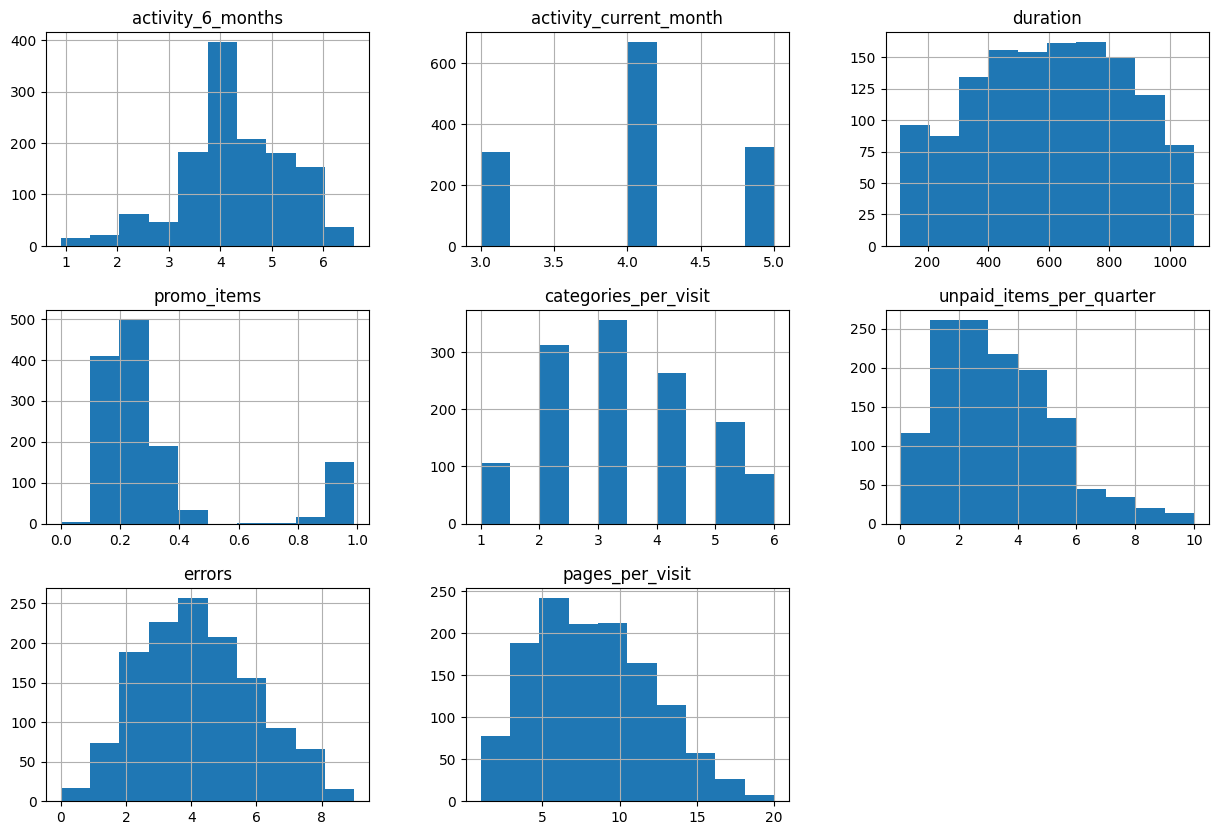

In [18]:
df_overview(df_main)

#### Датафрейм `df_revenue`

Первые пять строк датафрейма


,id,period,revenue
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6



Ключевая информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   period   3900 non-null   object 
 2   revenue  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None


Количество пропущенных значений по столбцам


id         0
period     0
revenue    0
dtype: int64


Описательные статистики для количественных данных


,revenue
count,3900.000000
mean,5025.696051
std,1777.704104
min,0.000000
25%,4590.150000
50%,4957.500000
75%,5363.000000
max,106862.200000



Гистограммы для количественных данных


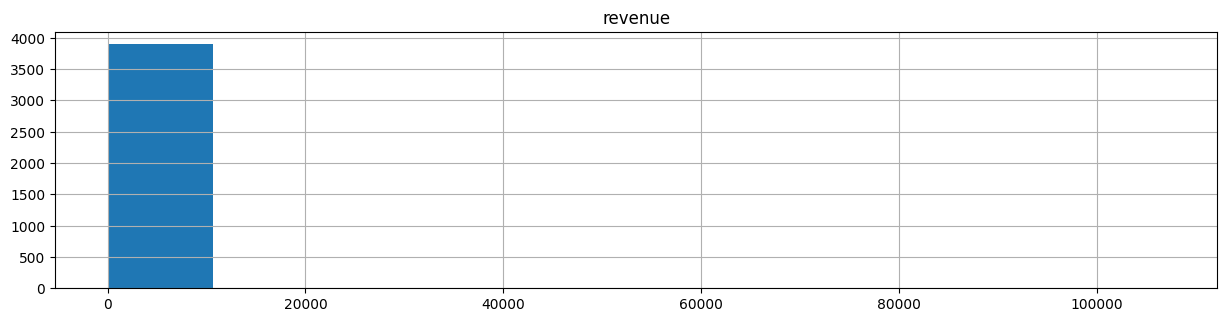

In [19]:
df_overview(df_revenue)

#### Датафрейм `df_time`

Первые пять строк датафрейма


,id,period,minutes
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13



Ключевая информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       2600 non-null   int64 
 1   period   2600 non-null   object
 2   minutes  2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None


Количество пропущенных значений по столбцам


id         0
period     0
minutes    0
dtype: int64


Описательные статистики для количественных данных


,minutes
count,2600.000000
mean,13.336154
std,4.080198
min,4.000000
25%,10.000000
50%,13.000000
75%,16.000000
max,23.000000



Гистограммы для количественных данных


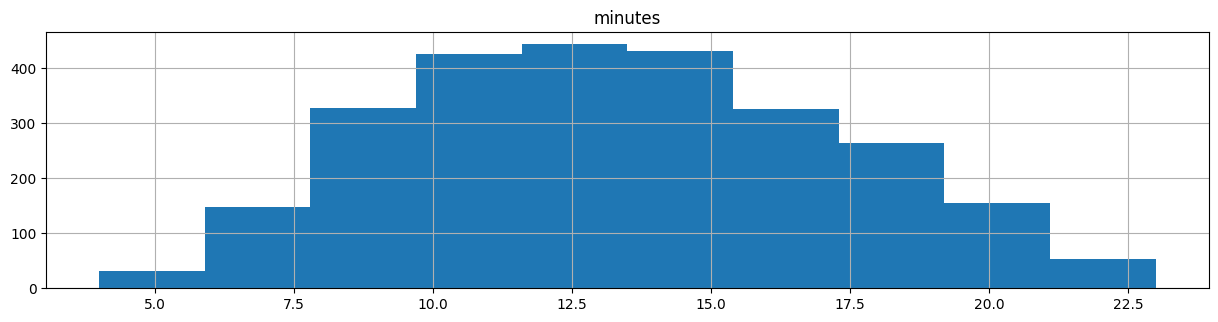

In [20]:
df_overview(df_time)

#### Датафрейм `df_profit`

Первые пять строк датафрейма


,id,profit
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21



Ключевая информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      1300 non-null   int64  
 1   profit  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None


Количество пропущенных значений по столбцам


id        0
profit    0
dtype: int64


Описательные статистики для количественных данных


,profit
count,1300.000000
mean,3.996631
std,1.013722
min,0.860000
25%,3.300000
50%,4.045000
75%,4.670000
max,7.430000



Гистограммы для количественных данных


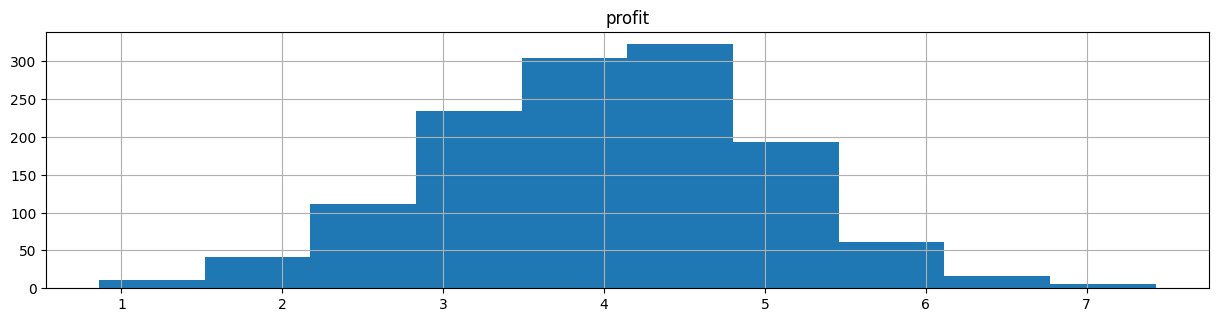

In [21]:
df_overview(df_profit)

**Выводы:**
* Данные загружены корректно и соответствуют описанию в постановке задачи
* В датафреймах не наблюдается пропущенных значений
* Количественные данные имеют тип `int64` или `float64`, категориальные - `object`. Преобразование типов данных не требуется.
* Гистограммы демонстрируют, что в данных наблюдаются выбросы, а также, что большинство количественных показвтелей не обладают нормальным распределением (исключения - прибыль и время, проведенное на сайте, распределение которых визуально близко к нормальному).

## Предварительная обработка данных

### Датафрейм `df_main`

#### Полные дубликаты

In [22]:
df_main.duplicated().sum()

0

Полные дубликаты не выявлены.

#### Дубликаты по ключевым признакам

Проверим наличие дубликатов по ключевым параметрам, исключив из рассмотрения идентификатор коровы `id`.

In [23]:
df_main.duplicated(subset = df_main.columns.tolist()[1:]).sum()

11

Выявлено 11 клиентов с полностью совпвдвющими признаками, оставим их в исследовании с учетом присвоенных им уникальных идентификаторов.

#### Поиск неявных дубликатов в значениях категориальных переменных

In [24]:
unique_categories(df_main)

Уникальные значения в столбце activity_trend
['Прежний уровень', 'Снизилась'] 

Уникальные значения в столбце service_type
['премиум', 'стандарт', 'стандартт'] 

Уникальные значения в столбце consent
['да', 'нет'] 

Уникальные значения в столбце popular_category
['Домашний текстиль', 'Косметика и аксесуары', 'Кухонная посуда', 'Мелкая бытовая техника и электроника', 'Техника для красоты и здоровья', 'Товары для детей'] 



Устраним неявные дубликаты в столбце `service_type`.

In [25]:
df_main['service_type'] = df_main['service_type'].str.replace('стандартт', 'стандарт')

### Датафрейм `df_revenue`

#### Полные дубликаты

In [26]:
df_revenue.duplicated().sum()

0

Полные дубликаты не выявлены. Для разных покупателей потенциально может совпадать выручка, поэтому не будем проводить поиск дубликатов по ключевым признакам.

#### Поиск неявных дубликатов в значениях категориальных переменных

In [27]:
unique_categories(df_revenue)

Уникальные значения в столбце period
['предыдущий_месяц', 'препредыдущий_месяц', 'текущий_месяц'] 



In [28]:
df_revenue[df_revenue['period'] == 'препредыдущий_месяц']['period'].count()

1300

Объекты с признаком `'препредыдущий_месяц'` составляют треть датафрейма, что позволяет сделать вывод, что это корректное обозначение, а не опечатка.

### Датафрейм `df_time`

#### Полные дубликаты

In [29]:
df_time.duplicated().sum()

0

Дубликаты не выявлены. Для разных покупателей потенциально может совпадать время на сайте, поэтому не будем проводить поиск дубликатов по ключевым признакам.

#### Поиск неявных дубликатов в значениях категориальных переменных

In [30]:
unique_categories(df_time)

Уникальные значения в столбце period
['предыдцщий_месяц', 'текущий_месяц'] 



Устраним опечатку, чтобы обеспечить единообразие признаков с датафреймом `df_revenue`

In [31]:
df_time['period'] = df_time['period'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')
unique_categories(df_time)

Уникальные значения в столбце period
['предыдущий_месяц', 'текущий_месяц'] 



### Датафрейм `df_profit`

**Полные дубликаты**

In [32]:
df_profit.duplicated().sum()

0

Дубликаты не выявлены. Для разных покупателей потенциально может прибыль, поэтому не будем проводить поиск дубликатов по ключевым признакам.

### Вывод: 
Проведен анализ наличия неявных дубликатов в значениях категориальных переменных, неявные дубликаты устранены.

## Исследовательский анализ данных

### Датафрейм `df_main`

Cред. кол-во коммуникаций за 6 мес.(шт.) - описательные статистики



count    1300.000000
mean        4.253769
std         1.014814
min         0.900000
25%         3.700000
50%         4.200000
75%         4.900000
max         6.600000
Name: activity_6_months, dtype: float64

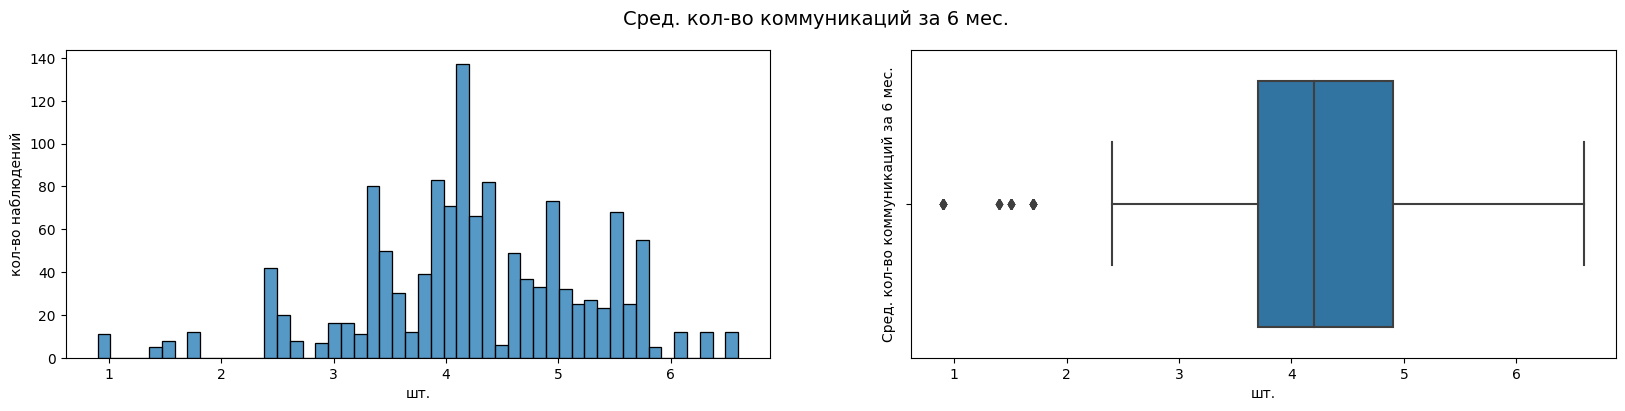

In [33]:
initial_data_analisys_numeric(df_main, 'activity_6_months', selected_bins = 50)

**Вывод:** Распределение не является нормальным, наблюдаются множественные пики. Все значения лежат в диапазоне от 1 до 7.

Cред. кол-во коммуникаций за текщий мес. - количество значений



activity_current_month
4    669
5    323
3    308
Name: activity_current_month, dtype: int64

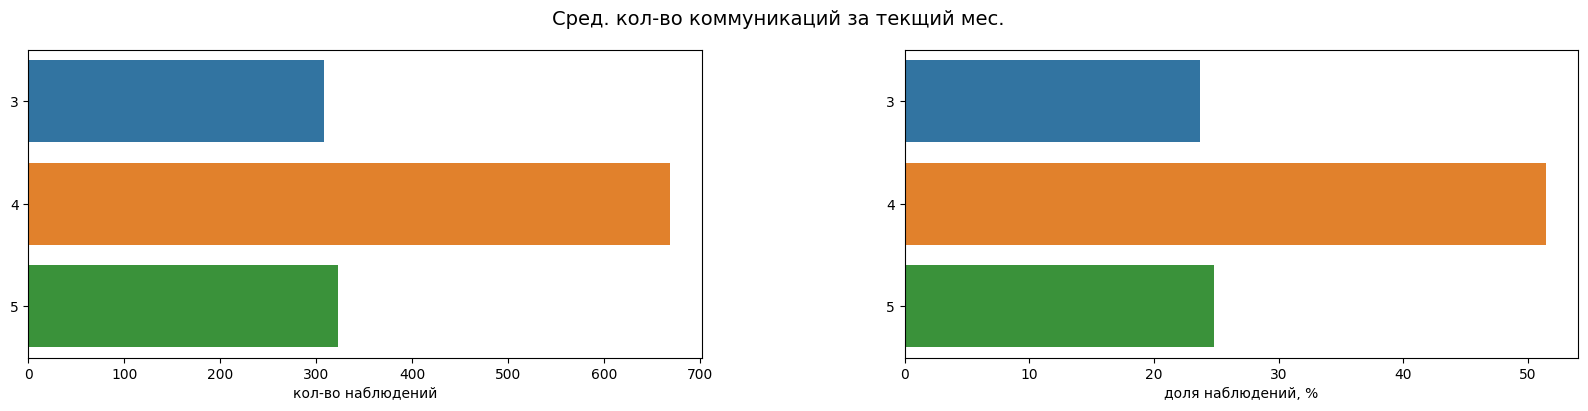

In [34]:
initial_data_analisys_category(df_main, 'activity_current_month')

**Вывод:** В текущем месяце было 3, 4 или 5 коммуникаций для каждого клиента. Больше всего (около 50%) пользователей получили 4 сообщения.

Время с момента регистрации(дни) - описательные статистики



count    1300.000000
mean      601.898462
std       249.856289
min       110.000000
25%       405.500000
50%       606.000000
75%       806.000000
max      1079.000000
Name: duration, dtype: float64

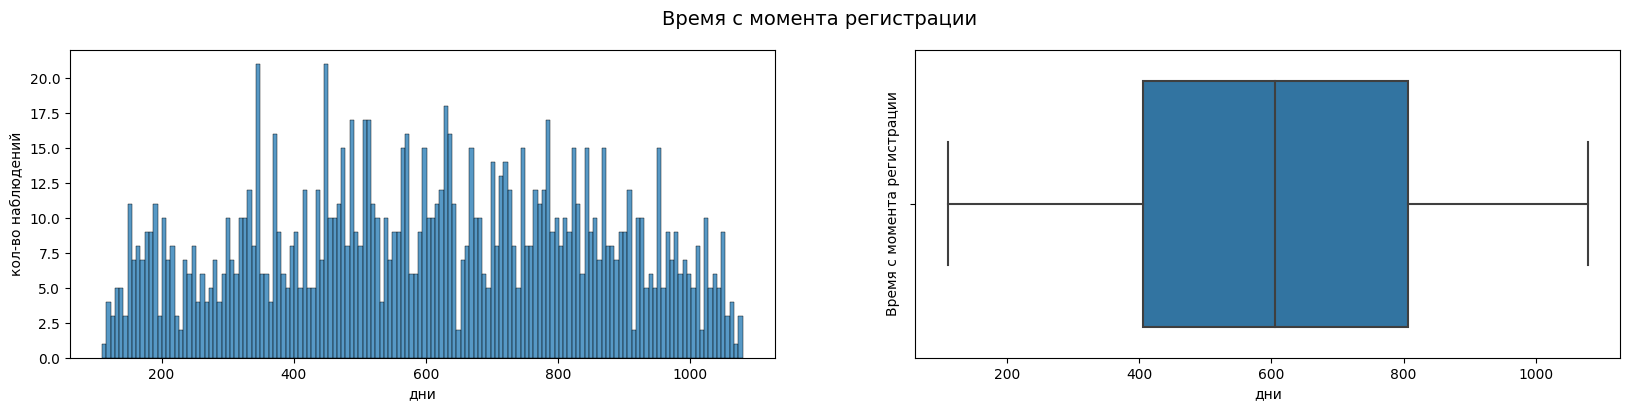

In [35]:
initial_data_analisys_numeric(df_main, 'duration', selected_bins = 150)

**Вывод:** Распределение не является нормальным, наблюдаются множественные пики. Все значения лежат в диапазоне от 110 до 1100.

Среднемесячная доля покупок по акции(Доля) - описательные статистики



count    1300.000000
mean        0.319808
std         0.249843
min         0.000000
25%         0.170000
50%         0.240000
75%         0.300000
max         0.990000
Name: promo_items, dtype: float64

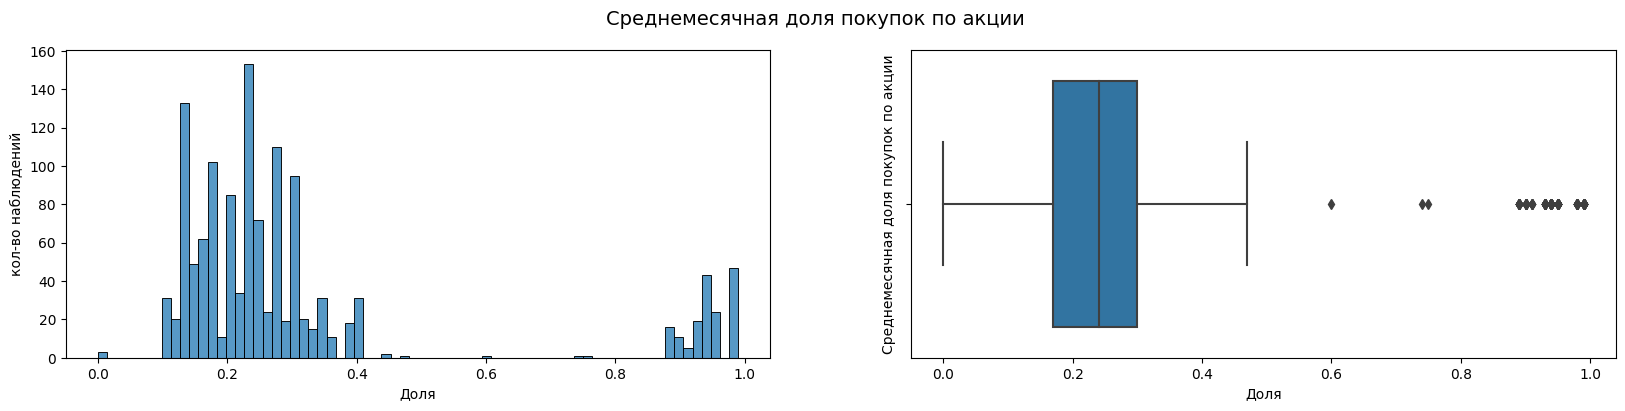

In [36]:
initial_data_analisys_numeric(df_main, 'promo_items', selected_bins = 70)

**Вывод:** Набледается 2 кластера покупателей: большинство и те, кто приобретает товары практически только по акции. Все значения лежат в диапазоне от 0 до 1, что соответсвует доле.

Сред. кол-во категорий за визит(шт.) - описательные статистики



count    1300.00000
mean        3.27000
std         1.35535
min         1.00000
25%         2.00000
50%         3.00000
75%         4.00000
max         6.00000
Name: categories_per_visit, dtype: float64

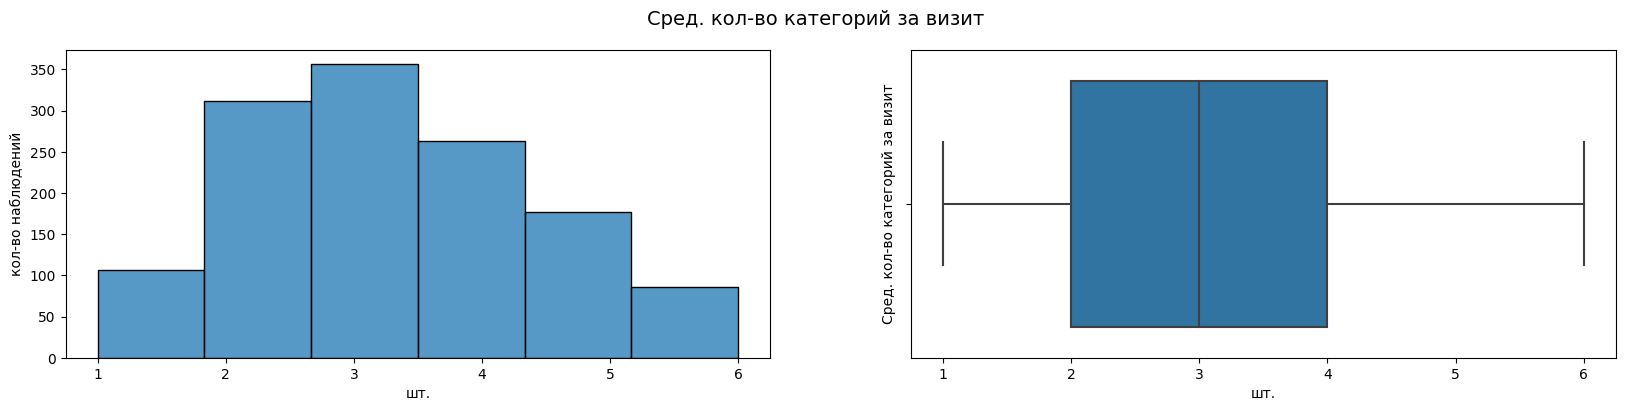

In [37]:
initial_data_analisys_numeric(df_main, 'categories_per_visit', selected_bins = 6)

**Вывод:** Все значения лежат в диапазоне от 1 до 6, что соответсвует количеству, включенных в исследование категорий. Медиана и мода равны 3.

Общее число неоплаченных товаров(шт.) - описательные статистики



count    1300.000000
mean        2.840000
std         1.971451
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: unpaid_items_per_quarter, dtype: float64

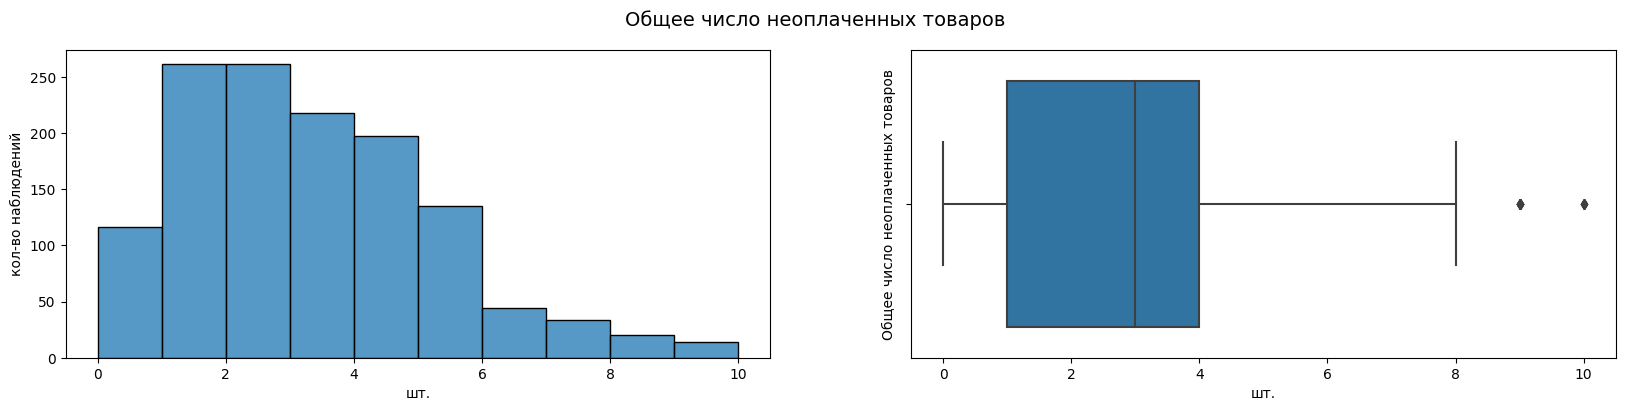

In [38]:
initial_data_analisys_numeric(df_main, 'unpaid_items_per_quarter', selected_bins = 10)

**Вывод:** Распределение не является нормальным, медиана равна 3. Все значения лежат в диапазоне от 1 до 10, 8 отказов и более - единичные случаи.

Число сбоев(шт.) - описательные статистики



count    1300.000000
mean        4.185385
std         1.955298
min         0.000000
25%         3.000000
50%         4.000000
75%         6.000000
max         9.000000
Name: errors, dtype: float64

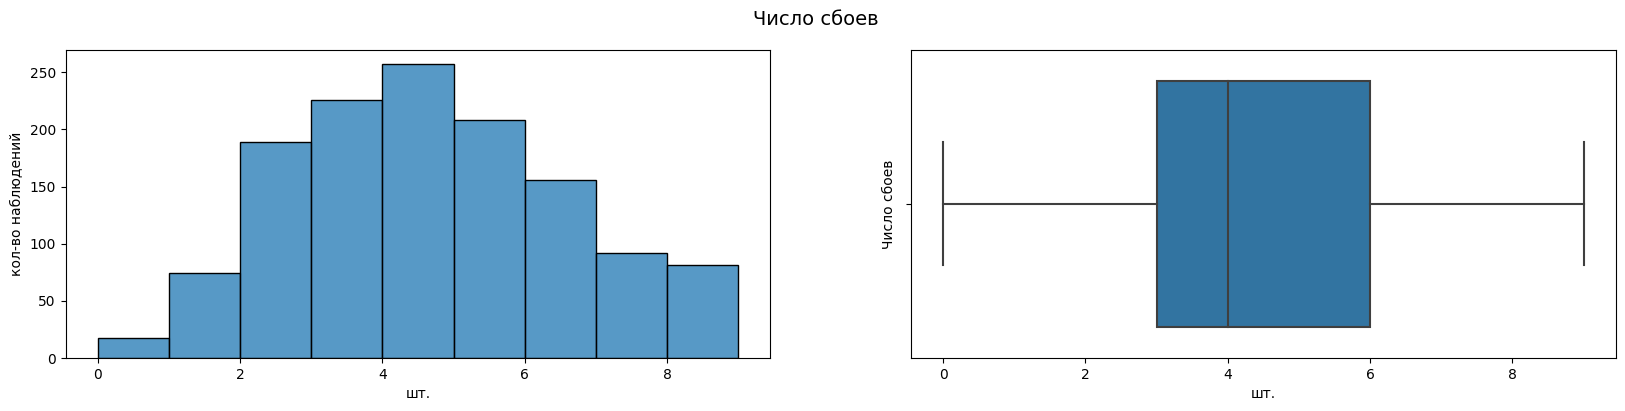

In [39]:
initial_data_analisys_numeric(df_main, 'errors', selected_bins = 9)

**Вывод:** Распределение не является нормальным, медиана равна 4. Все значения лежат в диапазоне от 0 до 9.

Среднее количество страниц за визит(шт.) - описательные статистики



count    1300.000000
mean        8.176923
std         3.978126
min         1.000000
25%         5.000000
50%         8.000000
75%        11.000000
max        20.000000
Name: pages_per_visit, dtype: float64

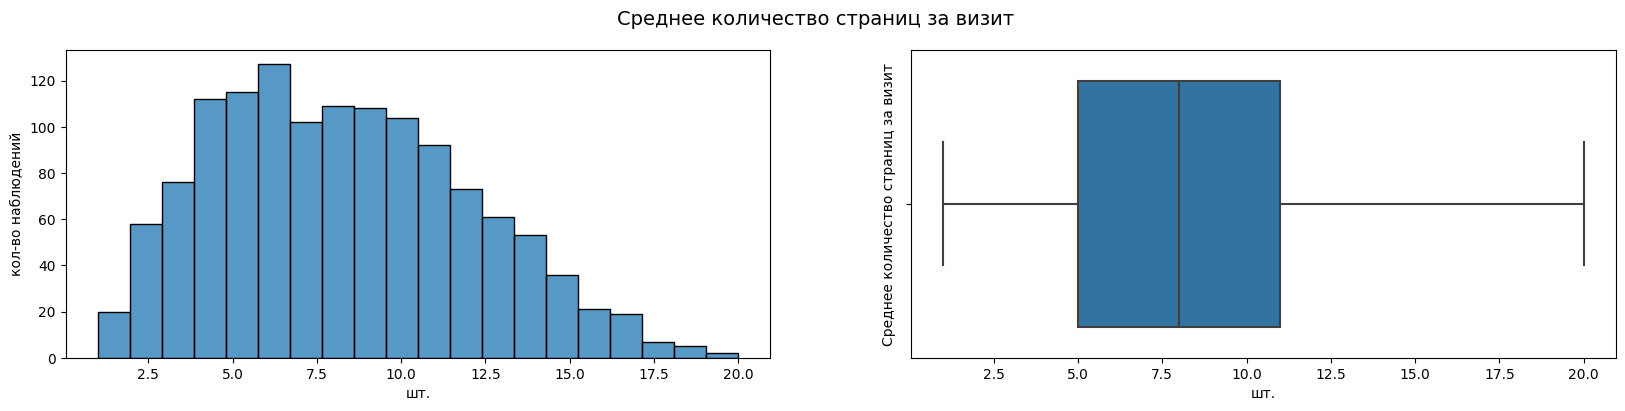

In [40]:
initial_data_analisys_numeric(df_main, 'pages_per_visit', selected_bins = 20)

**Вывод:** Все значения лежат в диапазоне от 1 до 20. Среднее и медианное значения - около 8.

Покупательская активность - количество значений



activity_trend
Прежний уровень    802
Снизилась          498
Name: activity_trend, dtype: int64

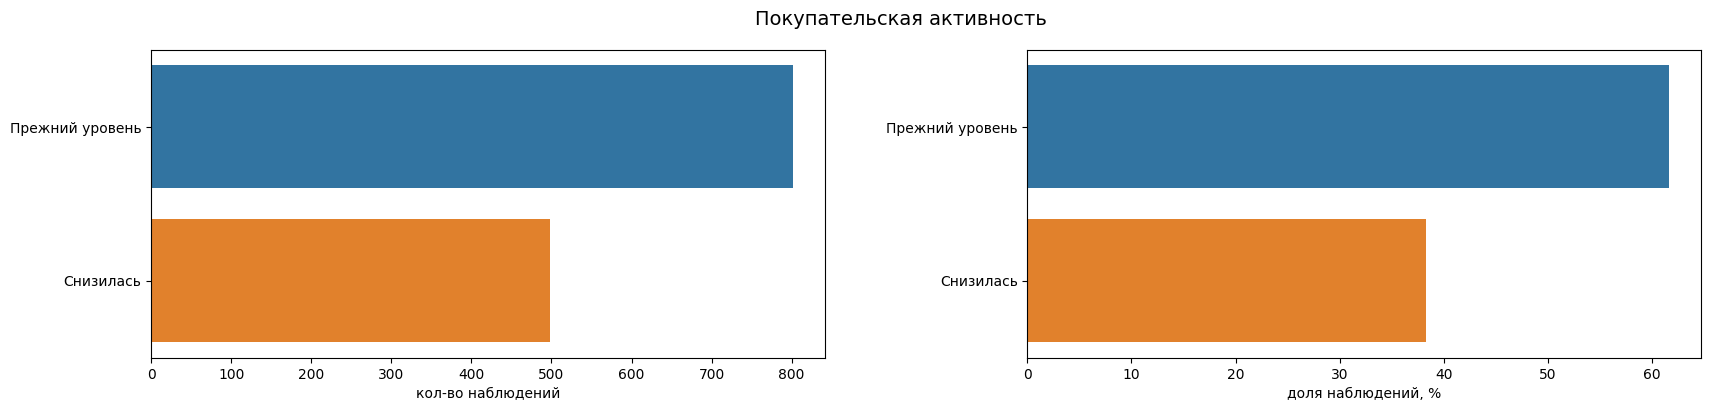

In [41]:
initial_data_analisys_category(df_main, 'activity_trend')

**Вывод:** Прежний уровень активности составляет 62% наблюдений, сниженный уровень - 38%. Необходимо учитывать дисбаланс классов в рамках дальнейшего исследования.

Тип сервиса - количество значений



service_type
стандарт    924
премиум     376
Name: service_type, dtype: int64

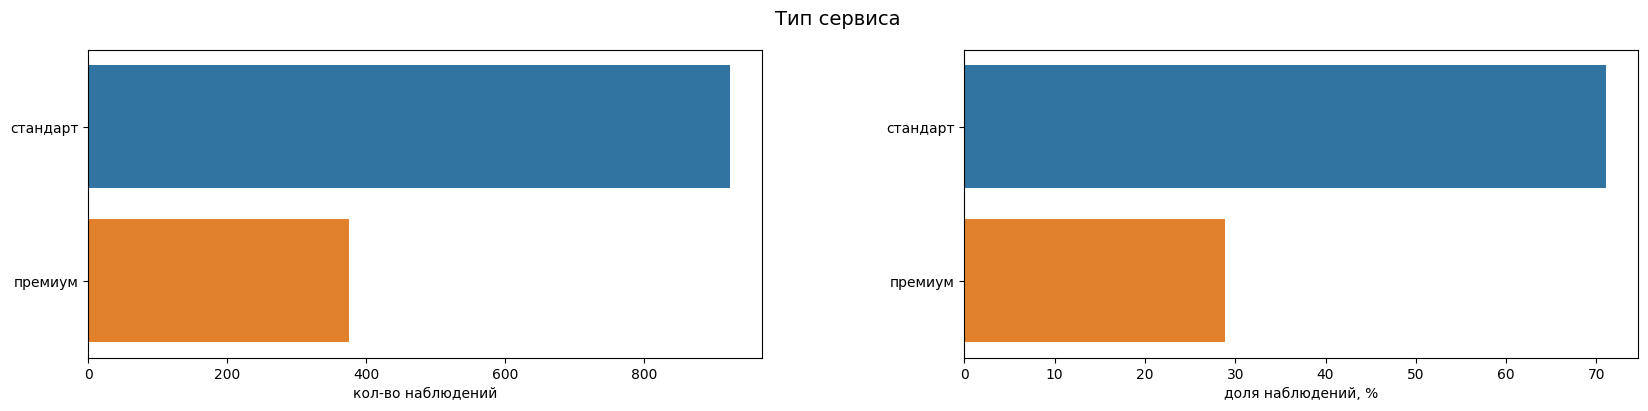

In [42]:
initial_data_analisys_category(df_main, 'service_type')

**Вывод:** Сервисом премиум пользуется порядка 30% пользователей.

Подписка на рассылки - количество значений



consent
да     962
нет    338
Name: consent, dtype: int64

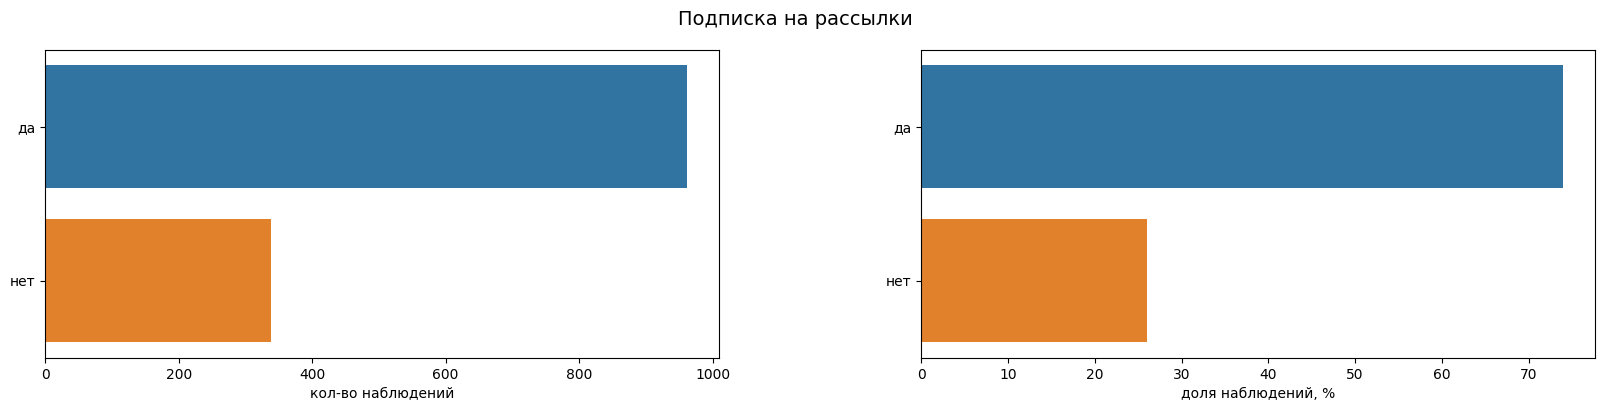

In [43]:
initial_data_analisys_category(df_main, 'consent')

**Вывод:** 74% пользователей дают согласие на получение дополнительных рассылок.

Самая популярная категория товаров - количество значений



popular_category
Товары для детей                        330
Домашний текстиль                       251
Косметика и аксесуары                   223
Техника для красоты и здоровья          184
Мелкая бытовая техника и электроника    174
Кухонная посуда                         138
Name: popular_category, dtype: int64

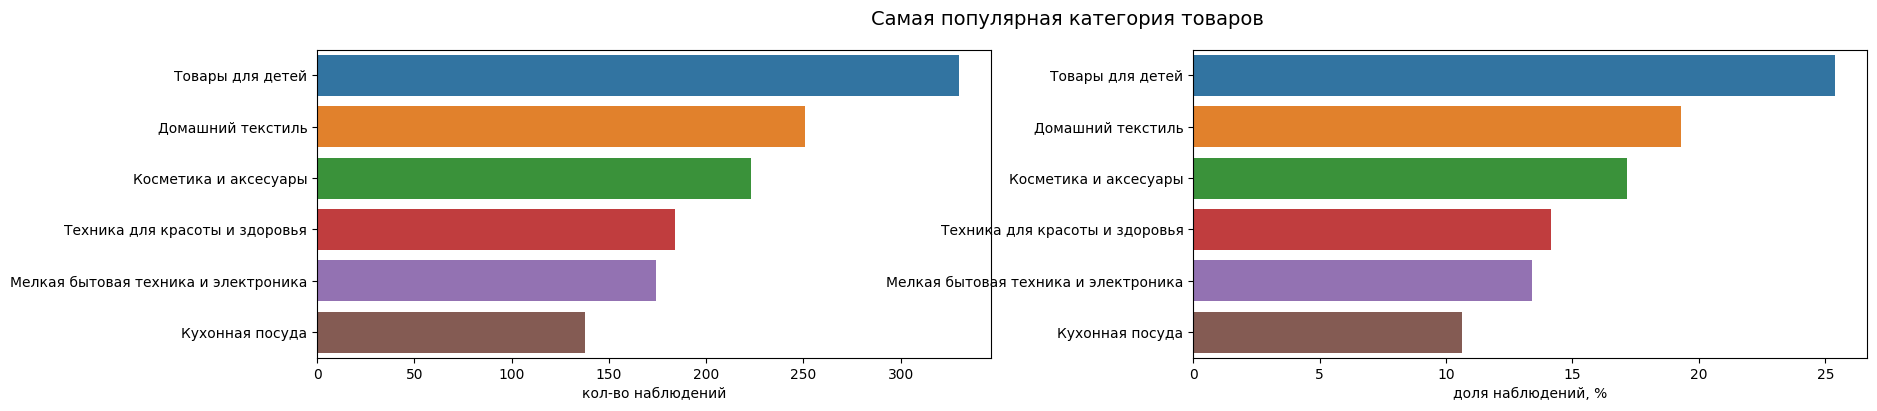

In [44]:
initial_data_analisys_category(df_main, 'popular_category')

**Вывод:** Самая популярная категория - товары для детей, наименее популярная - кухонная посуда.

### Датафрейм `df_revenue`

Выручка(ден. ед.) - описательные статистики



count      3900.000000
mean       5025.696051
std        1777.704104
min           0.000000
25%        4590.150000
50%        4957.500000
75%        5363.000000
max      106862.200000
Name: revenue, dtype: float64

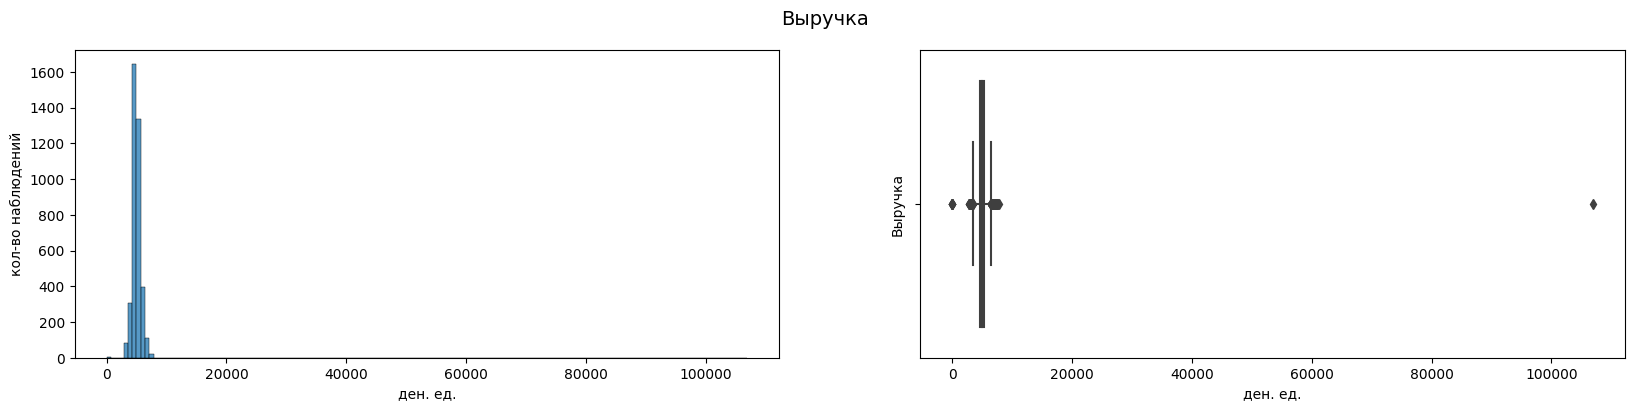

In [45]:
initial_data_analisys_numeric(df_revenue, 'revenue', selected_bins = 150)

В датафрейме наблюдается единичный выброс. Исключим его.

In [46]:
df_revenue = df_revenue.drop(
    index = df_revenue.loc[(df_revenue['revenue'] > 100000)].index
)

Выручка(ден. ед.) - описательные статистики



count    3899.00000
mean     4999.57743
std       706.99988
min         0.00000
25%      4590.10000
50%      4957.00000
75%      5363.00000
max      7799.40000
Name: revenue, dtype: float64

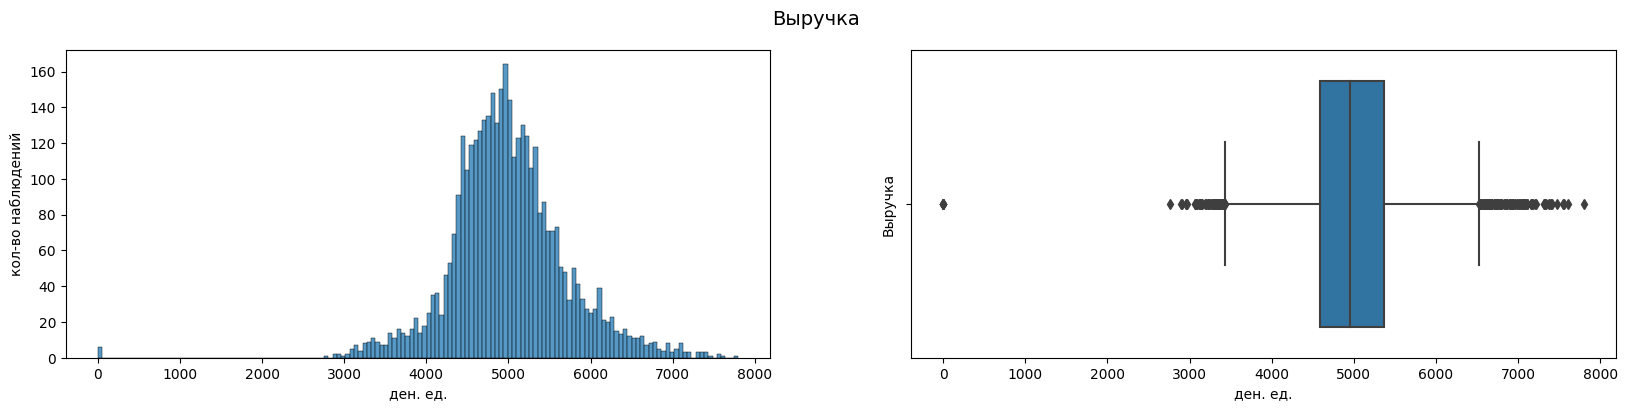

In [47]:
initial_data_analisys_numeric(df_revenue, 'revenue', selected_bins = 150)

Выручка в разбивке по месяцам

Препрдыдущий месяц

Выручка(ден. ед.) - описательные статистики



count    1300.000000
mean     4825.206923
std       405.979663
min         0.000000
25%      4583.000000
50%      4809.000000
75%      5053.500000
max      5663.000000
Name: revenue, dtype: float64

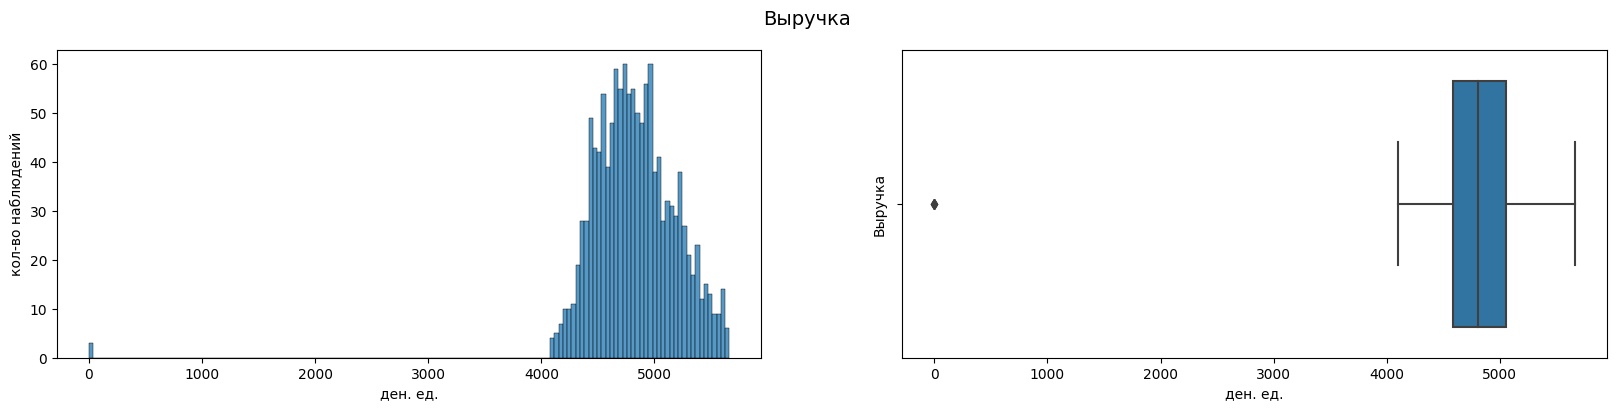

In [48]:
initial_data_analisys_numeric(df_revenue[df_revenue['period'] == 'препредыдущий_месяц'], 'revenue', selected_bins = 150)

Предыдущий месяц

Выручка(ден. ед.) - описательные статистики



count    1300.000000
mean     4936.920385
std       739.597997
min         0.000000
25%      4496.750000
50%      5005.000000
75%      5405.625000
max      6869.500000
Name: revenue, dtype: float64

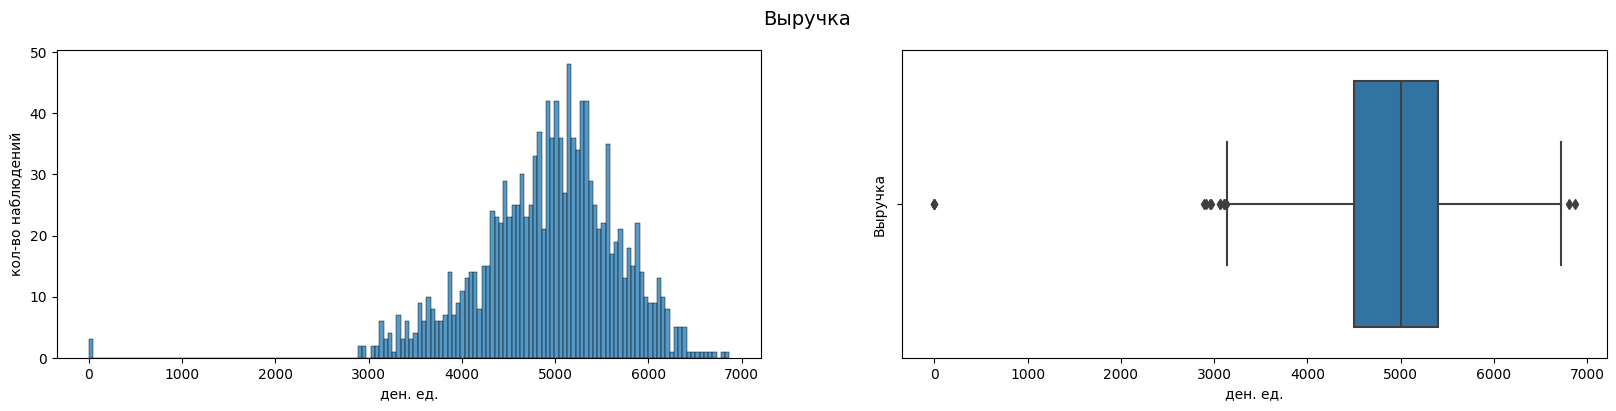

In [49]:
initial_data_analisys_numeric(df_revenue[df_revenue['period'] == 'предыдущий_месяц'], 'revenue', selected_bins = 150)

Текущий месяц

Выручка(ден. ед.) - описательные статистики



count    1299.000000
mean     5236.787452
std       835.474686
min      2758.700000
25%      4705.500000
50%      5179.600000
75%      5759.950000
max      7799.400000
Name: revenue, dtype: float64

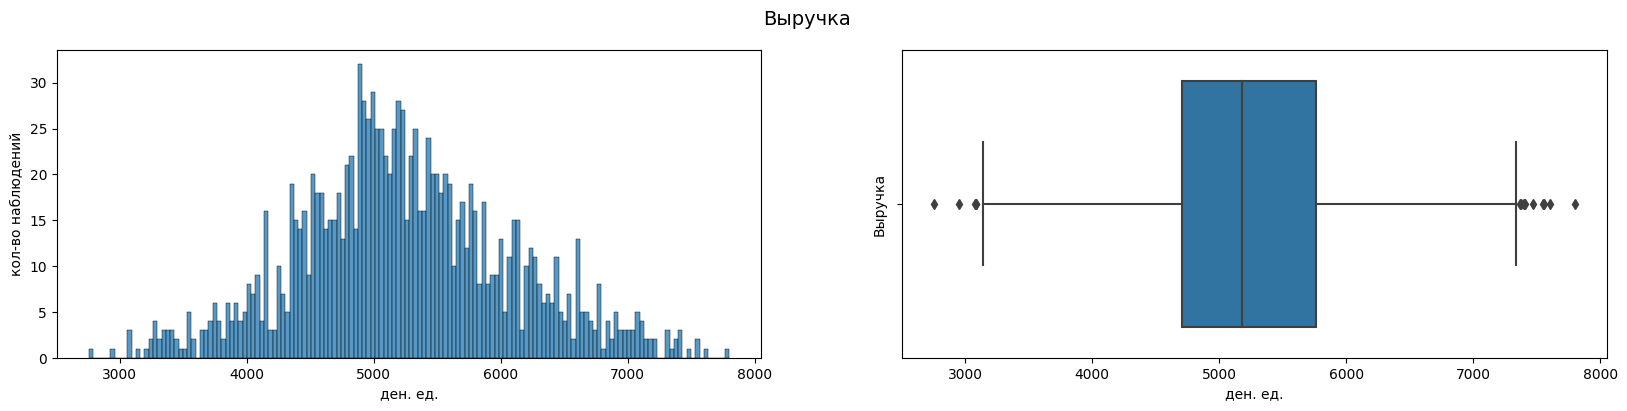

In [50]:
initial_data_analisys_numeric(df_revenue[df_revenue['period'] == 'текущий_месяц'], 'revenue', selected_bins = 150)

**Вывод:** Распределение выручки близко к нормальному. Среднее здачение - около 5000 ед. Стандартно отклонение - 707 ед. Выручка может принимать нулевое значение, если пользователь ничего не покупал в указанный период. При рассмотреии данных по периодам видно, что от месяца к месяцу растет дисперсия выручки.

Название периода - количество значений



period
предыдущий_месяц       1300
препредыдущий_месяц    1300
текущий_месяц          1299
Name: period, dtype: int64

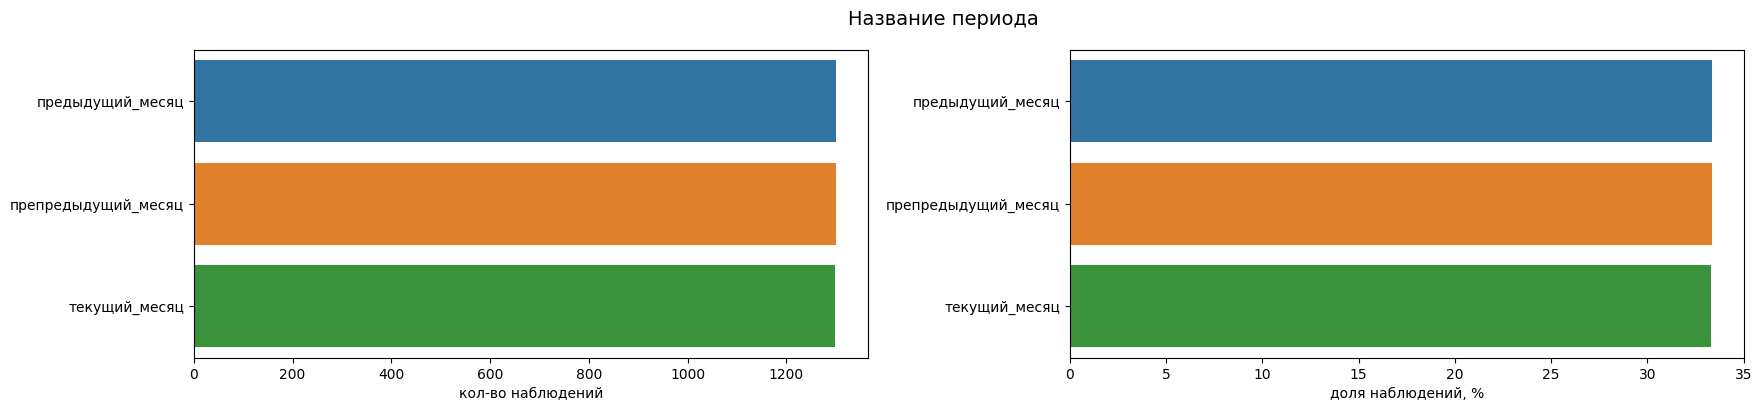

In [51]:
initial_data_analisys_category(df_revenue, 'period')

**Вывод:** количество наблюдений (покупателей) от месяцу к месяцу остается неизменным.

### Датафрейм `df_time`

Время на сайте(мин.) - описательные статистики



count    2600.000000
mean       13.336154
std         4.080198
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: minutes, dtype: float64

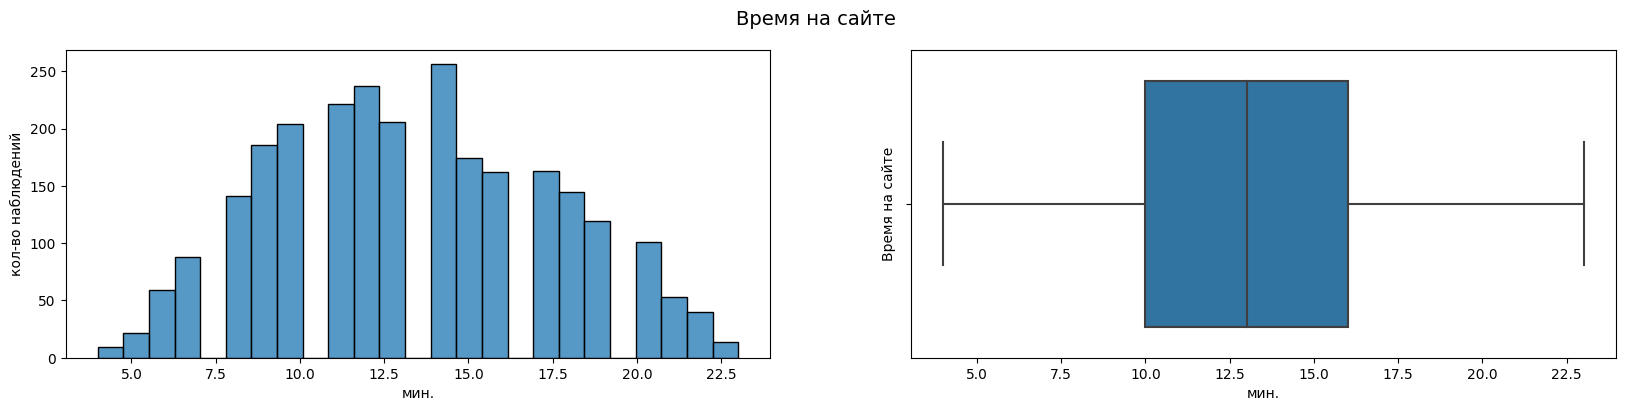

In [52]:
initial_data_analisys_numeric(df_time, 'minutes', selected_bins = 25)

Время в разбивке по месяцам

Предыдущий месяц

Время на сайте(мин.) - описательные статистики



count    1300.000000
mean       13.467692
std         3.932029
min         5.000000
25%        11.000000
50%        13.000000
75%        17.000000
max        23.000000
Name: minutes, dtype: float64

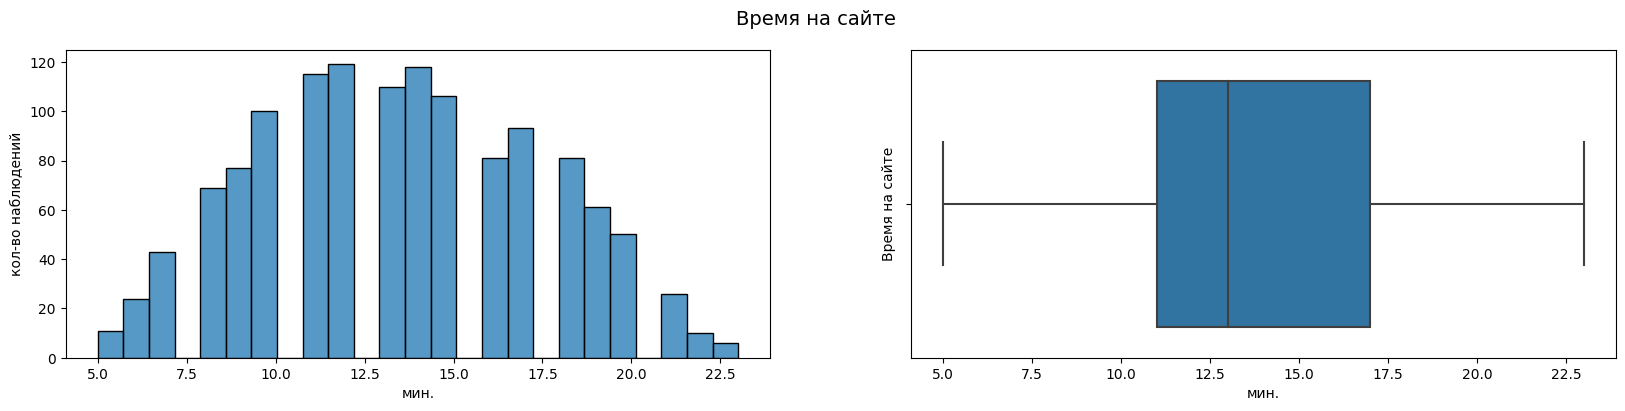

In [53]:
initial_data_analisys_numeric(df_time[df_time['period'] == 'предыдущий_месяц'], 'minutes', selected_bins = 25)

Текущий месяц

Время на сайте(мин.) - описательные статистики



count    1300.000000
mean       13.204615
std         4.220589
min         4.000000
25%        10.000000
50%        13.000000
75%        16.000000
max        23.000000
Name: minutes, dtype: float64

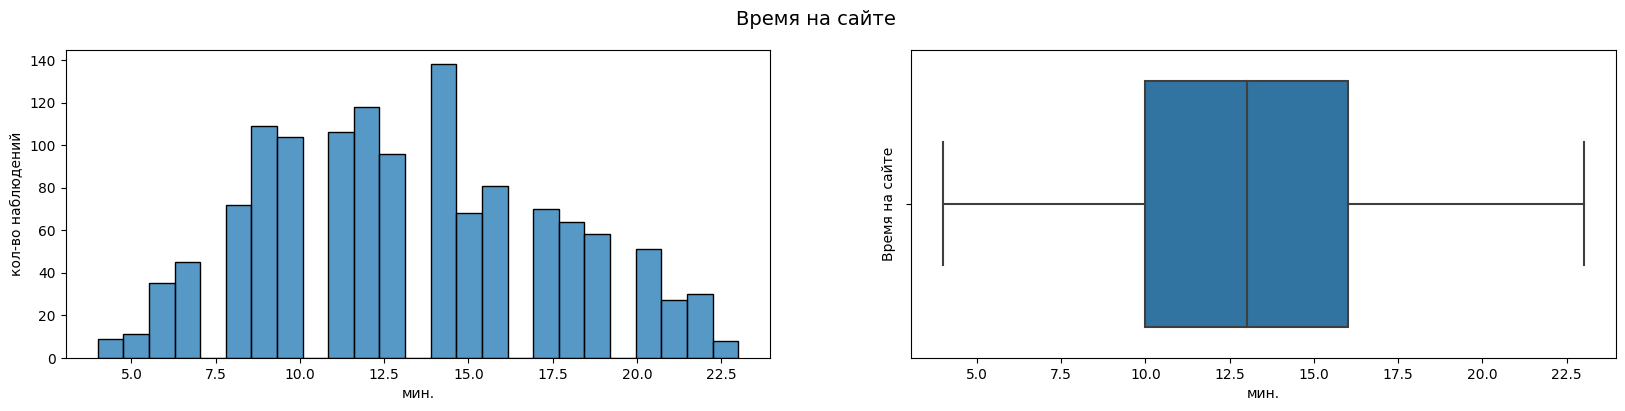

In [54]:
initial_data_analisys_numeric(df_time[df_time['period'] == 'текущий_месяц'], 'minutes', selected_bins = 25)

**Вывод:** Распределение не является нормальным, медиана и среднее близки к 13. Все значения лежат в диапазоне от 4 до 23 мин. Распределение времени от месяца к месяцу остается достаточно стабильным.

Название периода - количество значений



period
предыдущий_месяц    1300
текущий_месяц       1300
Name: period, dtype: int64

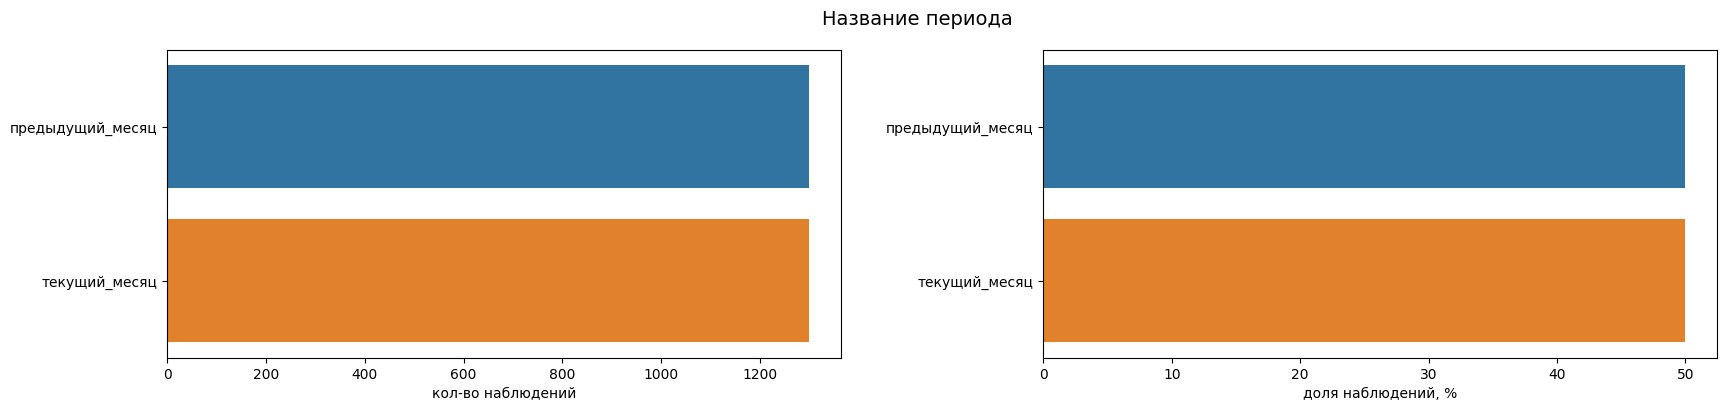

In [55]:
initial_data_analisys_category(df_time, 'period')

**Вывод:** количество наблюдений (пользователей) от месяцу к месяцу остается неизменным.

### Датафрейм `df_profit`

Прибыль(ден. ед.) - описательные статистики



count    1300.000000
mean        3.996631
std         1.013722
min         0.860000
25%         3.300000
50%         4.045000
75%         4.670000
max         7.430000
Name: profit, dtype: float64

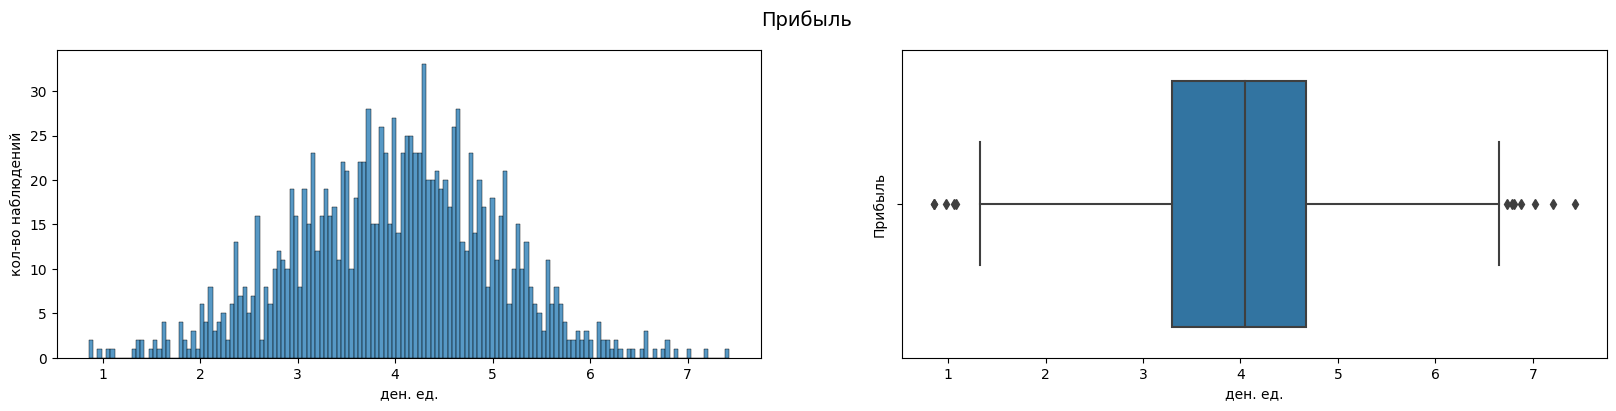

In [56]:
initial_data_analisys_numeric(df_profit, 'profit', selected_bins = 150)

Распределение не является нормальным, медиана и среднее близки к 4. Все значения лежат в диапазоне от 0.8 до 7.5 ед.

## Объединение данных

Сделаем отдельный столбец для выручки каждого периода.

In [57]:
df_revenue_pivot = df_revenue.pivot_table(index='id', columns='period', values='revenue', aggfunc='sum').reset_index()

In [58]:
df_revenue_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   1300 non-null   int64  
 1   предыдущий_месяц     1300 non-null   float64
 2   препредыдущий_месяц  1300 non-null   float64
 3   текущий_месяц        1299 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 40.8 KB


In [59]:
df_revenue_pivot = df_revenue_pivot.rename(columns={
    'предыдущий_месяц': 'revenue_1_month_ago', 
    'препредыдущий_месяц': 'revenue_2_months_ago',
    'текущий_месяц': 'revenue_current_month'
    }, errors='raise')

В рамках исследовательского анализа было удалено одно аномальное значение. Удалим оставшиеся значения для этого пользователя (удалим строку с пропущенным значением).

In [60]:
df_revenue_pivot = df_revenue_pivot.dropna()

In [61]:
df_revenue_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1299 entries, 0 to 1299
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1299 non-null   int64  
 1   revenue_1_month_ago    1299 non-null   float64
 2   revenue_2_months_ago   1299 non-null   float64
 3   revenue_current_month  1299 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 50.7 KB


Сделаем отдельный столбец для времени на сайте для каждого периода.

In [62]:
df_time_pivot = df_time.pivot_table(index='id', columns='period', values='minutes', aggfunc='sum').reset_index()

In [63]:
df_time_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   id                1300 non-null   int64
 1   предыдущий_месяц  1300 non-null   int64
 2   текущий_месяц     1300 non-null   int64
dtypes: int64(3)
memory usage: 30.6 KB


In [64]:
df_time_pivot = df_time_pivot.rename(columns={
    'предыдущий_месяц': 'time_1_month_ago', 
    'текущий_месяц': 'time_current_month'
    }, errors='raise')

In [65]:
df_time_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   id                  1300 non-null   int64
 1   time_1_month_ago    1300 non-null   int64
 2   time_current_month  1300 non-null   int64
dtypes: int64(3)
memory usage: 30.6 KB


Объединим таблицы и рассмотрим получившуюся таблицу

Первые пять строк датафрейма


,id,activity_trend,service_type,consent,activity_6_months,activity_current_month,duration,promo_items,popular_category,categories_per_visit,unpaid_items_per_quarter,errors,pages_per_visit,revenue_1_month_ago,revenue_2_months_ago,revenue_current_month,time_1_month_ago,time_current_month
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11



Ключевая информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1300 non-null   int64  
 1   activity_trend            1300 non-null   object 
 2   service_type              1300 non-null   object 
 3   consent                   1300 non-null   object 
 4   activity_6_months         1300 non-null   float64
 5   activity_current_month    1300 non-null   int64  
 6   duration                  1300 non-null   int64  
 7   promo_items               1300 non-null   float64
 8   popular_category          1300 non-null   object 
 9   categories_per_visit      1300 non-null   int64  
 10  unpaid_items_per_quarter  1300 non-null   int64  
 11  errors                    1300 non-null   int64  
 12  pages_per_visit           1300 non-null   int64  
 13  revenue_1_month_ago       129

None


Количество пропущенных значений по столбцам


id                          0
activity_trend              0
service_type                0
consent                     0
activity_6_months           0
activity_current_month      0
duration                    0
promo_items                 0
popular_category            0
categories_per_visit        0
unpaid_items_per_quarter    0
errors                      0
pages_per_visit             0
revenue_1_month_ago         1
revenue_2_months_ago        1
revenue_current_month       1
time_1_month_ago            0
time_current_month          0
dtype: int64


Описательные статистики для количественных данных


,activity_6_months,activity_current_month,duration,promo_items,categories_per_visit,unpaid_items_per_quarter,errors,pages_per_visit,revenue_1_month_ago,revenue_2_months_ago,revenue_current_month,time_1_month_ago,time_current_month
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000,1299.000000,1299.000000,1299.000000,1300.000000,1300.000000
mean,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923,4936.042725,4825.033102,5236.787452,13.467692,13.204615
std,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126,739.205300,406.087624,835.474686,3.932029,4.220589
min,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000,0.000000,0.000000,2758.700000,5.000000,4.000000
25%,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000,4496.500000,4583.000000,4705.500000,11.000000,10.000000
50%,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000,5004.500000,4809.000000,5179.600000,13.000000,13.000000
75%,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000,5404.250000,5054.000000,5759.950000,17.000000,16.000000
max,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000,6869.500000,5663.000000,7799.400000,23.000000,23.000000



Гистограммы для количественных данных


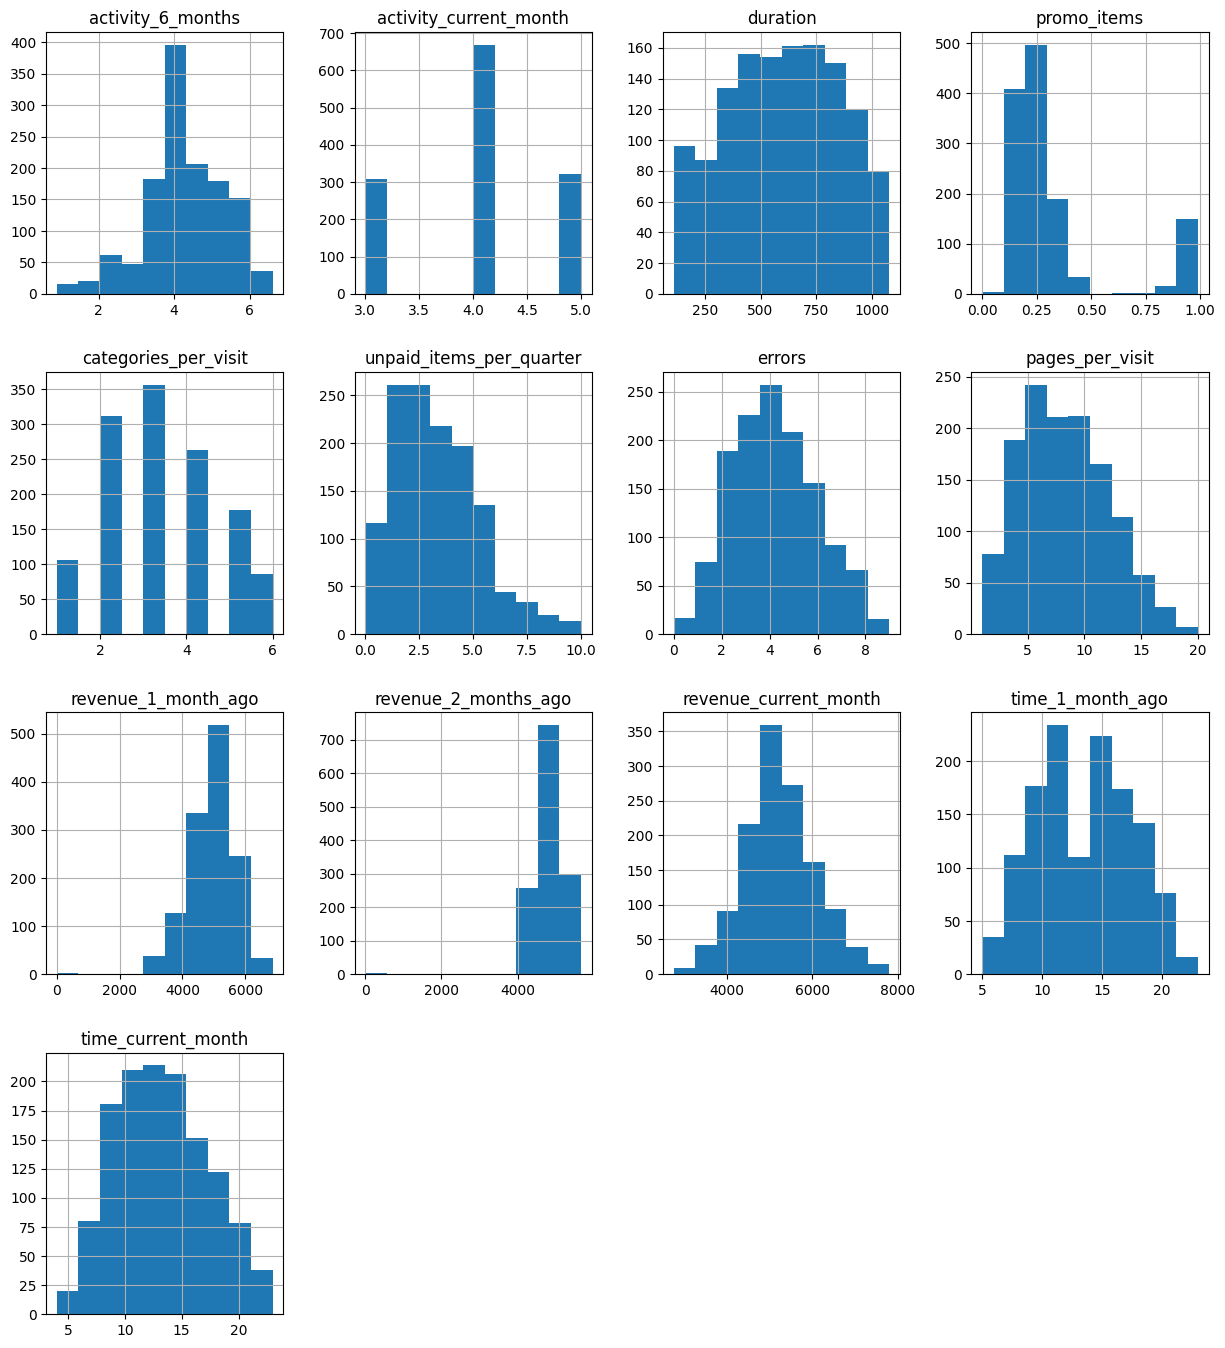

In [66]:
df_main = pd.merge(df_main, df_revenue_pivot, on = 'id', how = 'left')
df_main = pd.merge(df_main, df_time_pivot, on = 'id', how = 'left')
df_overview(df_main)

Данные успешно объединены. Наблюдаются пропущенные значения по выручке. Заполним пропуски нулями, т.к. можно предположить, что отсутствие данных означает отсутствие покупок.

In [67]:
df_main = df_main.fillna(value = 0)
df_main.isna().sum()

id                          0
activity_trend              0
service_type                0
consent                     0
activity_6_months           0
activity_current_month      0
duration                    0
promo_items                 0
popular_category            0
categories_per_visit        0
unpaid_items_per_quarter    0
errors                      0
pages_per_visit             0
revenue_1_month_ago         0
revenue_2_months_ago        0
revenue_current_month       0
time_1_month_ago            0
time_current_month          0
dtype: int64

Пропуски успешно заполнены.

В рамках исследования будем рассматривать пользователей, совершивших хотябы одну покупку в каждом месяце (выручка больше 0 в каждом из наблюдаемых месяцев), поскольку сервису целесообразно удерживать пользователей, которые совершаю покупки, а не только просматривают доступные продукты.

In [68]:
df_main[(df_main['revenue_current_month'] == 0) | (df_main['revenue_1_month_ago'] == 0) | (df_main['revenue_2_months_ago'] == 0)]

,id,activity_trend,service_type,consent,activity_6_months,activity_current_month,duration,promo_items,popular_category,categories_per_visit,unpaid_items_per_quarter,errors,pages_per_visit,revenue_1_month_ago,revenue_2_months_ago,revenue_current_month,time_1_month_ago,time_current_month
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14
9,215357,Снизилась,стандарт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5,0.0,0.0,5986.3,12,6
11,215359,Снизилась,стандарт,да,4.6,5,110,0.00,Домашний текстиль,4,2,4,2,0.0,0.0,4735.0,13,11
32,215380,Снизилась,премиум,нет,1.7,4,637,0.94,Техника для красоты и здоровья,3,2,4,7,0.0,0.0,0.0,12,14


In [69]:
df_main = df_main.drop(
    df_main[(df_main['revenue_current_month'] == 0) | (df_main['revenue_1_month_ago'] == 0) | (df_main['revenue_2_months_ago'] == 0)].index,
    axis = 0
)

In [70]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 1 to 1299
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1296 non-null   int64  
 1   activity_trend            1296 non-null   object 
 2   service_type              1296 non-null   object 
 3   consent                   1296 non-null   object 
 4   activity_6_months         1296 non-null   float64
 5   activity_current_month    1296 non-null   int64  
 6   duration                  1296 non-null   int64  
 7   promo_items               1296 non-null   float64
 8   popular_category          1296 non-null   object 
 9   categories_per_visit      1296 non-null   int64  
 10  unpaid_items_per_quarter  1296 non-null   int64  
 11  errors                    1296 non-null   int64  
 12  pages_per_visit           1296 non-null   int64  
 13  revenue_1_month_ago       1296 non-null   float64
 14  revenue_

**Вывод:** в таблице данных для моделирования после всех преобразований сохранено 1299 значений (99% от исходного датафрейма).

## Корреляционный анализ

### Корреляция Спирмена

Поскольку установлено, что рассматриваемые признаки не обладают нормальным распределением будем использовать коэффициент корреляции Спирмена, который устанавливает наличие/отсутствие монотонной зависимости между двумя признаками.

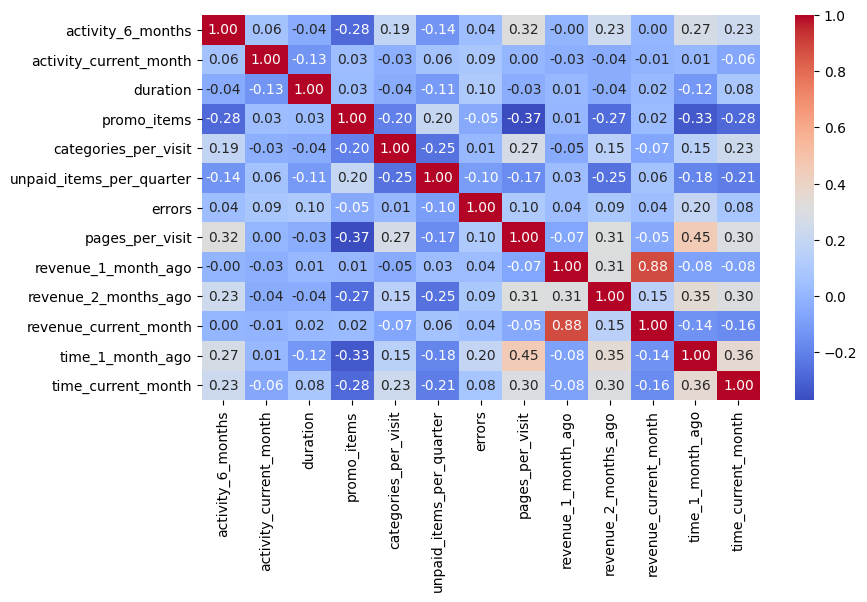

In [71]:
fig, ax = plt.subplots(figsize=(9,5))
sns.heatmap(df_main[df_main.columns.tolist()[1:]].corr(method='spearman'), annot=True, fmt='.2f', cmap='coolwarm', ax = ax);

**Вывод:** 
- Наблюдается высокая положительная корреляция выручки текущего месяца с выручкой прошлого месяца (коэффициент корреляции 0,88).
- Ярковыраженной мультиколлениарности между входными признаками не наблюдается, поскольку остальные коэффициенты корреляции не превышают 0,45.

### Корреляция $\phi_k$

Для определения взаимосвязи между категориальными признаками рассмотрим коэффициент корреляции $\phi_k$.

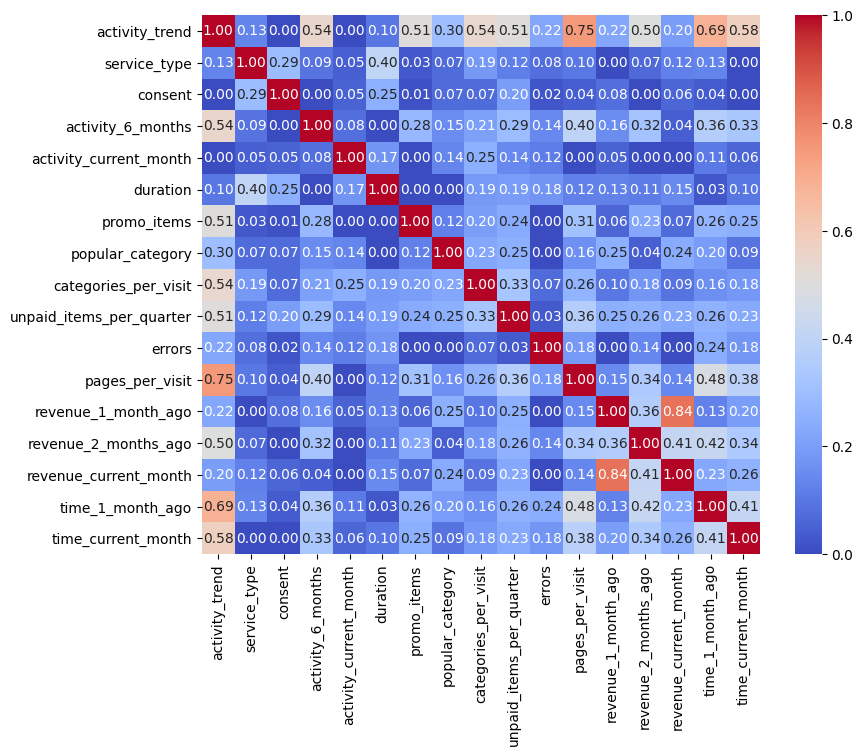

In [72]:
phi = df_main[df_main.columns.tolist()[1:]].phik_matrix(
    interval_cols = df_main.select_dtypes(include=np.number).columns.tolist()
)
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(phi, annot=True, fmt='.2f', cmap='coolwarm', ax = ax);

**Вывод:** 
- Ярковыраженной мультиколлениарности между входными признаками не наблюдается, поскольку коэффициенты корреляции не превышают 0,73.
- Можно предположить, что количество страниц, просматриваемых за одно посещение сайта, а также время на сайте в прошлом месяце являются значимыми переменными для прогнозирования уровня пользовательской активности (коэффициенты корреляции 0,76 и 0,70 соответственно).

## Выбор оптимальной модели

Для выбора оптимальной модели будем использованить общий пайплай для всех моделей и инструмент подбора гиперпараметров `RandomizedSearchCV`.

Модели и гиперпараметры:
- `DecisionTreeClassifier()`
      - `max_depth`
      - `max_features`
      - `min_samples_split`
- `KNeighborsClassifier()`
      - `n_neighbors`
- `LogisticRegression()`
      - Метод регуляризации:
          - `L1`
          - `L2`
      - Сила регуляризации `C`
- `SVC()`
      - Ядро:
          - `linear`
          - `poly`
          - `rbf`
          - `sigmoid`
      - Сила регуляризации `C`

Для масштабирования количественных данных будем использовать альтернативные скейлеры:
- `StandardScaler()`
- `MinMaxScaler()`
- `RobustScaler()`

В качестве метрики при выборе оптимальной модели будем использовать `ROC-AUC`, т.к.
- метрику можно использовать при дисбалансе классов, когда объектов с одним значением целевого признака больше, чем других
- постановка задачи не указывает на необходимость приоритетного исключения ошибок первого или второго рода

Закодируем целевой признак **Покупательская активность** (`activity_trend`):
* `0` - снизилась
* `1` - прежний уровень

Разобъем датафрейм на целевой и входящие признаки.

In [73]:
df_main['activity_trend_num'] = df_main['activity_trend'].apply(lambda x: 0 if x == 'Снизилась' else 1)
df_main.sample(5)

,id,activity_trend,service_type,consent,activity_6_months,activity_current_month,duration,promo_items,popular_category,categories_per_visit,unpaid_items_per_quarter,errors,pages_per_visit,revenue_1_month_ago,revenue_2_months_ago,revenue_current_month,time_1_month_ago,time_current_month,activity_trend_num
1044,216392,Прежний уровень,стандарт,да,4.6,5,356,0.17,Товары для детей,3,4,3,13,4973.0,4819.0,4969.1,20,9,1
573,215921,Снизилась,стандарт,нет,3.6,3,744,0.17,Товары для детей,2,1,4,15,4618.5,5208.0,4237.6,20,12,0
782,216130,Прежний уровень,стандарт,да,3.3,3,322,0.24,Товары для детей,5,0,5,3,5256.0,5139.0,5284.6,18,20,1
727,216075,Прежний уровень,стандарт,да,3.6,5,505,0.26,Косметика и аксесуары,6,1,3,15,5137.5,5433.0,5011.4,19,17,1
615,215963,Прежний уровень,премиум,да,4.6,3,702,0.17,Мелкая бытовая техника и электроника,3,3,5,15,5143.0,5293.0,5143.0,17,17,1


In [74]:
X_train, X_test, y_train, y_test = train_test_split(
    df_main.drop(
        [
            'id',
            'activity_trend',
            'activity_trend_num',
        ], 
        axis=1
    ),
    df_main['activity_trend_num'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_main['activity_trend_num']
)

Создадим пайплайн и найдем оптимальную модель.

In [75]:
ohe_columns = ['consent', 'popular_category']

ord_columns = ['service_type']

num_columns = X_train.select_dtypes(include=np.number).columns.tolist()

In [76]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='error', sparse=False)
        )
    ]
)

In [77]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'],
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [78]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [79]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [80]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__max_features': range(2, 6),
        'models__min_samples_split': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='saga', 
        )],
        'models__penalty' : ['l1', 'l2'],
        'models__C' : range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },

    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True, kernel = 'linear')],
        'models__kernel' : ['linear', 'poly'],
        'models__C' : range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

In [81]:
scoring = {
    'roc_auc_score': 'roc_auc',
    'accuracy_score': 'accuracy',
    'f1_score': 'f1'
}

In [82]:
start_time = time.time()

In [83]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid,
    scoring=scoring,
    refit = 'roc_auc_score',
    cv=5,
    n_iter=100,
    verbose=3,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


C:\Users\vikto\anaconda3\envs\practicum\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
65 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
65 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\vikto\anaconda3\envs\practicum\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\vikto\anaconda3\envs\practicum\lib\site-packages\sklearn\pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\vikto\anaconda3\envs\practicum\lib\site-packages\sklearn\tree\_classes.py", line 969, in fit
   

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse=False))]),
                                                                               ['consent',
                                                                                'popular_category']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_before_ord',
                                                                                                SimpleImp...
                                                               'passthrough']},
                                        {'models': [SVC(C=2, probability=True,
                                                        random_state=42)],
                                         'models__C': range(1, 6),
                                         'models__kernel': ['linear', 'poly',
                                                            'rbf', 'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42, refit='roc_auc_score',
                   scoring={'accuracy_score': 'accuracy', 'f1_score': 'f1',
                            'roc_auc_score': 'roc_auc'},
                   verbose=3)

In [84]:
finish_time = time.time()

In [85]:
print(f'Выбор оптимальноймодели занимает {round((finish_time - start_time) / 60, 1)} минут(ы)')

Выбор оптимальноймодели занимает 4.6 минут(ы)


**Оптимальная модель:**

In [86]:
randomized_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False))]),
                                                  ['consent',
                                                   'popular_category']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('...
                                                  ['service_type']),
                                                 ('num', StandardScaler(),
                                                  ['activity_6_months',
                                                   'activity_current_month',
                                                   'duration', 'promo_items',
                                                   'categories_per_visit',
                                                   'unpaid_items_per_quarter',
                                                   'errors', 'pages_per_visit',
                                                   'revenue_1_month_ago',
                                                   'revenue_2_months_ago',
                                                   'revenue_current_month',
                                                   'time_1_month_ago',
                                                   'time_current_month'])])),
                ('models', SVC(C=2, probability=True, random_state=42))])

In [87]:
print(f'Значение метрики ROC-AUC на обучающей выборке {randomized_search.best_score_:.2f}')

Значение метрики ROC-AUC на обучающей выборке 0.91


In [88]:
y_test_pred = randomized_search.predict_proba(X_test)
print(f'Значение метрики ROC-AUC на тестовой выборке {roc_auc_score(y_test, y_test_pred[:,1]):.2f}')

Значение метрики ROC-AUC на тестовой выборке 0.91


Модели, построенные при поиске оптимальной модели 

In [89]:
all_models = pd.DataFrame(randomized_search.cv_results_)
all_models.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__penalty,param_models__C,param_models,param_models__min_samples_split,param_models__max_features,...,std_test_accuracy_score,rank_test_accuracy_score,split0_test_f1_score,split1_test_f1_score,split2_test_f1_score,split3_test_f1_score,split4_test_f1_score,mean_test_f1_score,std_test_f1_score,rank_test_f1_score
0,0.058307,0.019850,0.043960,0.015198,MinMaxScaler(),l2,5,"LogisticRegression(random_state=42, solver='sa...",NaN,NaN,...,0.022088,6,0.886179,0.908397,0.901639,0.931727,0.932271,0.912043,0.017816,8
1,0.019366,0.003413,0.046297,0.018963,passthrough,NaN,NaN,DecisionTreeClassifier(random_state=42),5,3,...,0.034703,47,0.820896,0.804687,0.828125,0.877470,0.847059,0.835647,0.024948,47
2,0.036077,0.002942,0.024379,0.003330,StandardScaler(),l2,1,"LogisticRegression(random_state=42, solver='sa...",NaN,NaN,...,0.021711,11,0.881633,0.904215,0.905350,0.931174,0.923695,0.909213,0.017278,12
3,0.025838,0.003490,0.022802,0.001473,RobustScaler(),NaN,NaN,DecisionTreeClassifier(random_state=42),5,4,...,0.033283,32,0.862745,0.806324,0.880000,0.869231,0.841270,0.851914,0.026068,32
4,0.017702,0.000726,0.018982,0.001261,passthrough,NaN,NaN,DecisionTreeClassifier(random_state=42),4,5,...,0.027741,35,0.864662,0.807843,0.844262,0.874074,0.857143,0.849597,0.023043,35


In [95]:
all_models.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 38 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   mean_fit_time                    100 non-null    float64
 1   std_fit_time                     100 non-null    float64
 2   mean_score_time                  100 non-null    float64
 3   std_score_time                   100 non-null    float64
 4   param_preprocessor__num          100 non-null    object 
 5   param_models__penalty            7 non-null      object 
 6   param_models__C                  29 non-null     object 
 7   param_models                     100 non-null    object 
 8   param_models__min_samples_split  70 non-null     object 
 9   param_models__max_features       70 non-null     object 
 10  param_models__max_depth          70 non-null     object 
 11  param_models__kernel             22 non-null     object 
 12  param_models__n_neighbo

In [102]:
all_models.loc[:, ['param_models', 'param_models__kernel', 'mean_test_roc_auc_score']].sort_values(by = 'mean_test_roc_auc_score', ascending = False).head(10)

,param_models,param_models__kernel,mean_test_roc_auc_score
57,"SVC(C=2, probability=True, random_state=42)",rbf,0.911589
63,"SVC(C=2, probability=True, random_state=42)",rbf,0.909881
8,"SVC(C=2, probability=True, random_state=42)",rbf,0.908752
34,"SVC(C=2, probability=True, random_state=42)",rbf,0.906696
48,"SVC(C=2, probability=True, random_state=42)",rbf,0.906405
0,"LogisticRegression(random_state=42, solver='sa...",NaN,0.905888
80,"LogisticRegression(random_state=42, solver='sa...",NaN,0.905216
40,"LogisticRegression(random_state=42, solver='sa...",NaN,0.904942
13,"LogisticRegression(random_state=42, solver='sa...",NaN,0.904900
82,"LogisticRegression(random_state=42, solver='sa...",NaN,0.904787


In [103]:
randomized_search.best_score_

0.9115892338619611

In [90]:
all_models[all_models['mean_test_roc_auc_score'] >= 0.9].sort_values(by = 'mean_fit_time').head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__penalty,param_models__C,param_models,param_models__min_samples_split,param_models__max_features,...,std_test_accuracy_score,rank_test_accuracy_score,split0_test_f1_score,split1_test_f1_score,split2_test_f1_score,split3_test_f1_score,split4_test_f1_score,mean_test_f1_score,std_test_f1_score,rank_test_f1_score
2,0.036077,0.002942,0.024379,0.003330,StandardScaler(),l2,1,"LogisticRegression(random_state=42, solver='sa...",NaN,NaN,...,0.021711,11,0.881633,0.904215,0.905350,0.931174,0.923695,0.909213,0.017278,12
40,0.044709,0.002112,0.021521,0.000794,RobustScaler(),l2,5,"LogisticRegression(random_state=42, solver='sa...",NaN,NaN,...,0.021236,10,0.881633,0.908397,0.905350,0.931174,0.923695,0.910050,0.017116,10
82,0.046889,0.002682,0.021525,0.002125,StandardScaler(),l1,5,"LogisticRegression(random_state=42, solver='sa...",NaN,NaN,...,0.020486,12,0.881633,0.908397,0.905350,0.931174,0.919355,0.909182,0.016501,13
80,0.050424,0.007652,0.019903,0.002084,MinMaxScaler(),l1,4,"LogisticRegression(random_state=42, solver='sa...",NaN,NaN,...,0.021250,12,0.881633,0.908397,0.901639,0.927419,0.928000,0.909418,0.017337,11
13,0.053617,0.005042,0.023907,0.002942,RobustScaler(),l1,3,"LogisticRegression(random_state=42, solver='sa...",NaN,NaN,...,0.020486,12,0.881633,0.908397,0.905350,0.931174,0.919355,0.909182,0.016501,13
0,0.058307,0.019850,0.043960,0.015198,MinMaxScaler(),l2,5,"LogisticRegression(random_state=42, solver='sa...",NaN,NaN,...,0.022088,6,0.886179,0.908397,0.901639,0.931727,0.932271,0.912043,0.017816,8
75,0.084944,0.004972,0.023227,0.001401,MinMaxScaler(),NaN,3,"SVC(C=2, probability=True, random_state=42)",NaN,NaN,...,0.015144,5,0.904762,0.900763,0.910569,0.924901,0.928571,0.913913,0.010986,5
14,0.093150,0.003108,0.028165,0.001424,StandardScaler(),NaN,1,"SVC(C=2, probability=True, random_state=42)",NaN,NaN,...,0.014471,19,0.892308,0.892193,0.915663,0.904943,0.907692,0.902560,0.009124,19
85,0.106084,0.007917,0.026999,0.003738,MinMaxScaler(),NaN,5,"SVC(C=2, probability=True, random_state=42)",NaN,NaN,...,0.017233,6,0.896000,0.900763,0.914980,0.924901,0.928571,0.913043,0.012859,6
57,0.138224,0.004599,0.038315,0.001823,StandardScaler(),NaN,2,"SVC(C=2, probability=True, random_state=42)",NaN,NaN,...,0.026016,1,0.898438,0.893939,0.931727,0.936508,0.932271,0.918577,0.018410,1


In [91]:
all_models.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 38 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   mean_fit_time                    100 non-null    float64
 1   std_fit_time                     100 non-null    float64
 2   mean_score_time                  100 non-null    float64
 3   std_score_time                   100 non-null    float64
 4   param_preprocessor__num          100 non-null    object 
 5   param_models__penalty            7 non-null      object 
 6   param_models__C                  29 non-null     object 
 7   param_models                     100 non-null    object 
 8   param_models__min_samples_split  70 non-null     object 
 9   param_models__max_features       70 non-null     object 
 10  param_models__max_depth          70 non-null     object 
 11  param_models__kernel             22 non-null     object 
 12  param_models__n_neighbo

**Вывод:** оптимальной моделью для прогнозирования покупательской активности является модель логистической регрессии с L1-регуляризацией и параметром, характерезующим степень регуляризации `C=1`.

## Анализ важности признаков

Для анализа признаков будем использовать метод SHAP.

In [92]:
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']

In [93]:
X_train_processed = pd.DataFrame(preprocessor.transform(X_train), columns = preprocessor.get_feature_names_out())
X_test_processed = pd.DataFrame(preprocessor.transform(X_test), columns = preprocessor.get_feature_names_out())

In [ ]:
explainer = shap.KernelExplainer(randomized_search.best_estimator_.named_steps['models'].predict_proba, X_train_processed)
shap_values = explainer(X_train_processed)

Using 972 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/972 [00:00<?, ?it/s]

**График `beeswarm`**

In [ ]:
shap.plots.beeswarm(shap_values)

**График `bar`**

In [ ]:
shap.plots.bar(shap_values)

**Интерпритация**

Метод SHAP позволил выделить 9 ключевых, признаков, помогающих предсказать покупательскую активность. Разделим признаки на подкатегории:

**Поведение на сайте:**
* Среднее число страниц за визит - чем больше число станиц за визит, тем выше вероятность сохранения покупательской активности.
* Время, которое покупатель провел на сайте в прошлом месяце - чем выше значение, тем выше вероятность сохранения покупательской активности.
* Время, которое покупатель провел на сайте в текущем месяце - чем выше значение, тем выше вероятность сохранения покупательской активности.

**Продуктовое поведение:**
* Среднее число категорий, просматриваемое за визит - чем больше категорий просматривает пользователь, тем выше вероятность сохранения покупательской активности.
* Число неоплаченных товаров в корзине - чем больше таких продуктов, тем выше вероятность снижения покупательской активности.
* Cреднемесячная доля покупок по акции - чем выше доля покупок по акции, тем выше вероятность снижения покупательской активности.
* Если у пользователя любимая категория "Мелкая бытовая техника и электроника", вероятность сохранения покупательской активности повышается.

**Коммуникация с клиентом** - из признаков, характеризующих коммуникацию с клиентом в ТОП-9 значимых признаков вошел только 1:
* Cреднемесячное значение маркетинговых коммуникаций за 6 месяцев - чем выше значение, тем выше вероятность сохранения покупательской активности. Важно отметить, что признак, характеризующий количество коммуникаций в текущем месяце не вошеел в ТОП-9 значимых, что позволяет сделать вывод, что важна стабильная ежемесячная коммуникация с клиентами.

**Финансовое поведение:**
* Выручка 2 месяца незад - чем выше значения, тем выше вероятность сохранения покупательской активности. Выручка текущего месяца оказалась незначимой, предположительно, из-за высокой корреляции с выручкой текущего месяца. Более финансово обеспеченные клиенты, тратящие больше, с большей вероятностью сохраняют покупательскую активность.

## Анализ целевого сегмента

### Целевой сегмент

В качестве целевого сегмента выбран сегмент клиентов со снижающейся покупательской активностью и наиболее высокой прибыльностью. Определим значение третьего квартиля прибыльности и отберем клиентов с прибыльностью не менее этого значения.

In [ ]:
df_main = pd.merge(df_main, df_profit, on = 'id', how = 'left')
df_main.head()

In [ ]:
cut_off = np.quantile(df_main['profit'], 0.75)
cut_off

In [ ]:
df_main['top_profit'] = df_main['profit'].apply(lambda x: 0 if x < cut_off else 1)
df_main.head()

### Аналитическое исследование

Анализ целевого сегмента будем проводить, сравнивая его характеристики
* с сегментом с высокой прибылью, но без снижения покупательской активности
* с сегментом низкой и средней прибыли

In [ ]:
df_top_profit = df_main[df_main['top_profit'] == 1]
df_low_profit = df_main[df_main['top_profit'] == 0]

#### Количественные признаки

**Поведение на сайте**

In [ ]:
target_data_analisys_numeric(df_top_profit, df_low_profit, 'pages_per_visit', 'activity_trend', selected_bins = 20)

**Вывод:** В сегменте с высокой прибылью, как и в сегменте с низкой и средней прибылью, покупательская активность сохраняется чаще, если покупатель просматривает больше страниц (7 и более страниц за визит).

In [ ]:
target_data_analisys_numeric(df_top_profit, df_low_profit, 'time_1_month_ago', 'activity_trend', selected_bins = 20)

In [ ]:
target_data_analisys_numeric(df_top_profit, df_low_profit, 'time_current_month', 'activity_trend', selected_bins = 20)

**Вывод:** В сегменте с высокой прибылью распределение времени, проведенного на сайте в текущем и прошлом месяце, в разрезе покупательской активности существенно не отличается. Для обоих сегментов время на сайте более 12,5 существенно увеличивает частоту сохранения покупательской активности.

Рассмотрим динамику времени на сайте от месяца к месяцу. Для этого будем использовать медианное значение времени по группам.

In [ ]:
df_time = pd.merge(df_time, df_main.loc[:, ['id', 'activity_trend', 'top_profit']], on = 'id', how = 'left')

In [ ]:
target_data_analisys_dynamics(df_time[df_time['top_profit'] == 1].pivot_table(index = ['period', 'activity_trend', ], 
                                values = 'minutes', 
                                aggfunc = 'median').reset_index(), 
                              df_time[df_time['top_profit'] == 0].pivot_table(index = ['period', 'activity_trend', ], 
                                values = 'minutes', 
                                aggfunc = 'median').reset_index(), 
                              'minutes', 
                              'period',
                              'activity_trend')

**Вывод:** Медианное время на сайте покупателей с высокой прибылью соспоставимо с аокупатялями с низкой и средней прибылью. В текущем месяце покупатели с высокой прибылью и сохраняющимся уровнем покупательской активности провели на сайте больше времени, чем покупатели со средней и низкой прибылью. В группе покупателей со снизившейся покупательской активностью различий не наблюдается.

**Продуктовое поведение:**

In [ ]:
target_data_analisys_numeric(df_top_profit, df_low_profit, 'promo_items', 'activity_trend', selected_bins = 20)

**Вывод:** Покупатели с высокой прибылью, как покупатели со средней и низкой прибылью делятся на 2 кластера: с умеренной долей покупок по акции и тех, кто стремится максимально использовать промоакции. Среди покупателей с высокой прибылью реже встречаются покупатели, которые покупают в основном товары по акции.

In [ ]:
target_data_analisys_numeric(df_top_profit, df_low_profit, 'categories_per_visit', 'activity_trend', selected_bins = 6)

**Вывод:** У покупателей с высокой прибылью реже снижается покупательская активность при просмотре 2-3 категорий, чем у покупателей со средней и низкой прибылью, это позволяет предположить, что для сохранения покупательской активности покупателей с высокой прибылью требуется меньше стимулировать для просмотра дополнительных категорий.

In [ ]:
target_data_analisys_numeric(df_top_profit, df_low_profit, 'unpaid_items_per_quarter', 'activity_trend', selected_bins = 10)

**Вывод:** К оличество неоплпченных покупок в корзине принципиально не отличается у покупателей с высокой прибылью и покупателей со средней и низкой прибылью. Для обеих групп, если неоплаченных покупок 6 и более, у таких клиентов чаще всего снижается покупательская активность.

**Коммуникация с клиентом**

In [ ]:
target_data_analisys_numeric(df_top_profit, df_low_profit, 'activity_6_months', 'activity_trend', selected_bins = 20)

**Выаод:** В сегменте с высокой прибылью, как и в сегменте с низкой и средней прибылью, покупательская активность сохраняется чаще, если покупатель получает в среднем 4 и более маркетинговых коммуникаций в месяц. Для сохранения покупательской активности сегмента с высокой прибылью можно рекомендовать стабильную ежемесячную маркетинговую коммуникацию на уровне 4-6 рез в месяц.

**Финансовое поведение**

In [ ]:
target_data_analisys_numeric(df_top_profit, df_low_profit, 'revenue_current_month', 'activity_trend', selected_bins = 50)

In [ ]:
target_data_analisys_numeric(df_top_profit, df_low_profit, 'revenue_2_months_ago', 'activity_trend', selected_bins = 50)

**Вывод:** выручка текущего месяца по покупателям с выссокой прибылью имеет большую дисперсию, чем по покупателям со средней и низкой прибылью.

In [ ]:
df_revenue = pd.merge(df_revenue, df_main.loc[:, ['id', 'activity_trend', 'top_profit']], on = 'id', how = 'left')

In [ ]:
def recategorize_period(period):
    if period == 'текущий_месяц':
        return '1_текущий_месяц'
    elif period == 'предыдущий_месяц':
        return '2_предыдущий_месяц'
    elif period == 'препредыдущий_месяц':
        return '3_препредыдущий_месяц'
    else:
        raise ValueError('Value not mapped: ' + str(period))

In [ ]:
df_revenue['period'] = df_revenue['period'].apply(recategorize_period)

In [ ]:
target_data_analisys_dynamics(df_revenue[df_revenue['top_profit'] == 1].pivot_table(index = ['period', 'activity_trend', ], 
                                values = 'revenue', 
                                aggfunc = 'median').reset_index().sort_values(by = 'period'), 
                              df_revenue[df_revenue['top_profit'] == 0].pivot_table(index = ['period', 'activity_trend', ], 
                                values = 'revenue', 
                                aggfunc = 'median').reset_index().sort_values(by = 'period'), 
                              'revenue', 
                              'period',
                              'activity_trend')

#### Категориальные перизнаки

In [ ]:
target_data_analisys_category(df_top_profit[df_top_profit['activity_trend_num'] == 0], 
                              df_top_profit[df_top_profit['activity_trend_num'] == 1], 
                              df_low_profit[df_low_profit['activity_trend_num'] == 0], 
                              df_low_profit[df_low_profit['activity_trend_num'] == 1], 
                              'service_type')

**Вывод:** Целевой сегмент чаще пользуется подпиской премиум, чем сегмент с высокой прибылью и устойчивой покупателькой способностью. Подписка премиум не является значимым фактором, влияющим на сохранение покупательской активности высокоприбыльных клиентов.

In [ ]:
target_data_analisys_category(df_top_profit[df_top_profit['activity_trend_num'] == 0], 
                              df_top_profit[df_top_profit['activity_trend_num'] == 1], 
                              df_low_profit[df_low_profit['activity_trend_num'] == 0], 
                              df_low_profit[df_low_profit['activity_trend_num'] == 1], 
                              'consent')

**Вывод:** Покупатели с высокой прибылью чаще дают согласие на подписку на рассылки, покупатели с низкой прибылью.

In [ ]:
target_data_analisys_category(df_top_profit[df_top_profit['activity_trend_num'] == 0], 
                              df_top_profit[df_top_profit['activity_trend_num'] == 1], 
                              df_low_profit[df_low_profit['activity_trend_num'] == 0], 
                              df_low_profit[df_low_profit['activity_trend_num'] == 1], 
                              'popular_category')

**Вывод:** ТОП-3 категорий товаров целевого сегмента: 
1. товары для детей
2. косметика и аксессуары
3. домашний текстиль

### Общий вывод

Поведение на сайте, продуктовое поведение, коммуникация с клиентом не отличается существенным образом для целевого сегмента от иных сегментов. Это значит, что возможно сформировать перечень универсальных рекомендаций, релевантных как для сегмента с высокой прибылью, так и для сегмента с низкой и средней прибылью.

## Выводы и рекомендации

### Общие выводы

Исследование выполнено с целью разработать рекомендации по маркетинговой коммуникации для сегмента постоянных покупателей интернет-магазина со снижающейся покупательской активностью и наиболее высокой прибыльностью (целевой сегмент). В основе рекомендаций лежат результаты моделирования средсвами машинного обучения с отбором признаков, которые являются значимыми для прогнозирования покупительской активности. Дополнительно проведено аналитическое исследование, сравнивающее целевой сегмент и его поведение с иными покупателями: с низкими и средними показателями по прибыли, покупателями с высокими показателями по прибыли, но сохраняющими высокий уровень покупательской октивности.

Перед моделированием выполнен обзор и исследовательский анализ данных, по результатом которого единичные аномальные значения. По итогам этих шагов сохранено 99% исходных данных. В рамках исследования выявлен дисбаланс классов (соотношение классов в целевом признаке - 60/40), который учитывался при дальнейшем моделировании.

Выполнен корреляционный анализ c использованием корреляции Спирмен и корреляции $\phi_k$. Выявлены единичные случаи мультикорреляции, большенство признаков не коррелируют.

Для выявления факторов, позволяющих предсказать покупательское поведения, проведен выбор  оптимальной модели из следующего перечня:
* дерево решений (`DecisionTreeClassifier()`)
* k ближайших соседей (`KNeighborsClassifier()`)
* логистическая регрессия (`LogisticRegression()`)
* метод опрных векторов (`SVC()`)
Для каждой модели был выбран ряд гиперпараметров, а также рассмотрены альтернативные методы стандартизации количественных данных.

В качестве метрики для поиска оптимальной модели высбрана ROC-AUC из-за дисбаланса классов, а также с учетом отсутствия необходимости фокусно работать с ошибками первого или второго рода в рамках текущего исследования.

оптимальной моделью для прогнозирования покупательской активности является модель логистической регрессии с L1-регуляризацией и параметром, характерезующим степень регуляризации `C=1`. Метрика ROC-AUC на обучающей выборке равна 0,91, на тестовой - 0,89.

Для интерпритации оптимальной модели и отбора значимых для прогнозирования признаков использован медод SHAP. Выделено 9 ключевых, признаков, помогающих предсказать покупательскую активность.

**Поведение на сайте (ТОП-3 признака):**
* Среднее число страниц за визит - чем больше число станиц за визит, тем выше вероятность сохранения покупательской активности.
* Время, которое покупатель провел на сайте в прошлом месяце - чем выше значение, тем выше вероятность сохранения покупательской активности.
* Время, которое покупатель провел на сайте в текущем месяце - чем выше значение, тем выше вероятность сохранения покупательской активности.

**Продуктовое поведение:**
* Среднее число категорий, просматриваемое за визит - чем больше категорий просматривает пользователь, тем выше вероятность сохранения покупательской активности.
* Число неоплаченных товаров в корзине - чем больше таких продуктов, тем выше вероятность снижения покупательской активности.
* Cреднемесячная доля покупок по акции - чем выше доля покупок по акции, тем выше вероятность снижения покупательской активности.
* Если у пользователя любимая категория "Мелкая бытовая техника и электроника", вероятность сохранения покупательской активности повышается.

**Коммуникация с клиентом** - из признаков, характеризующих коммуникацию с клиентом в ТОП-9 значимых признаков вошел только 1:
* Cреднемесячное значение маркетинговых коммуникаций за 6 месяцев - чем выше значение, тем выше вероятность сохранения покупательской активности. Важно отметить, что признак, характеризующий количество коммуникаций в текущем месяце не вошеел в ТОП-9 значимых, что позволяет сделать вывод, что важна стабильная ежемесячная коммуникация с клиентами.

**Финансовое поведение:**
* Выручка в прошлом месяце - чем выше значения, тем выше вероятность сохранения покупательской активности. Выручка текущего месяца оказалась незначимой, предположительно, из-за высокой корреляции с выручкой текущего месяца. Более финансово обеспеченные клиенты, тратящие больше, с большей вероятностью сохраняют покупательскую активность. 

**В рамках анализа целевого сегмента выявлено**, что по ключевым признакам, позволяющим предсказать покупательскую активность, поведение целевого сегмента (клиенты с высокой прибылью) не отличается существенным образом от сегмента клиентов со средней и низкой прибылью. В качестве исключения выявлено, что у покупателей с высокой прибылью реже снижается покупательская активность при просмотре 2-3 категорий, чем у покупателей со средней и низкой прибылью, это позволяет предположить, что для сохранения покупательской активности покупателей с высокой прибылью требуется меньше стимулировать для просмотра дополнительных категорий. ТОП-3 категорий товаров целевого сегмента: товары для детей, косметика и аксессуары, домашний текстиль. С учетом исследования можно сделать вывод, что нижеследующие рекомендации являются универсальными и релевантными для целевого сегмента.

### Рекомендации
**Коммуникация с клиентом**
* Рекомендуется осуществлять стабильные ежемесячные маркетинговые коммуникации со среднемесячным количеством сообщений на уровне 4-6 шт. Повышенная коммуникативная активность текущего месяца не позволяет сохранить стабильно высокую покупательскую активность клиентов.
* Поскольку увеличение числа просматриваемых категорий за визит повышает вероятность сохранения покупательской активности, целесообразно формировать коммуникацию, предлагая покупателям просматривать новые категории товаров. Для уточнения данной рекомендации можно провести дополнительное исследование продуктового поведения и сформировать модель оптимальных рекомендаций новых категорий для клиентов.

**Поведение на сайте**
* Поведение на сайте является ключевым фактором, обеспечивающим сохранение покупательской активности, поэтому работа с интерфейсом сайта должна быть приоритетной для заказчика.
* Для уеличения числа просмотров разных страниц за визит можно рекомендовать:
    * Удобный интерфейс с интуитивным переходом от одного продукта к другому
    * Персонализированные рекомендации товаров из популярных у покупателя категорий, а также новых категорий
* Для увеличения времени, которое покупатель проводит на сайте, можно рекомендовать:
    * Использование на сайте комфортного/приятного для покупателей дизайна
    * Использование красивых/привлекательных фотографий товаров, стимулирующих покупателей их рассматривать
    * Использование компактного, но информативного описания ключевых характеристик товаров
    * Реализацию функции сравнения характеристик товаров на сайте

**Продуктовое поведение**
* Высокая доля покупок продуктов по акции на сайте предсказывает снижение покупательской активности в долгосрочной перспективе, поэтому:
    * кластер клиентов, покупающих продукты практически только по акции, можно исключить из перечня фокусных сегментов
    * использование промо-акций, которое могло быть эффективным на этапе привлечения пользователей, не является эффективным инструментом сохранения покупательской активности
    * промо-акции должны быть направлены на
        * увеличение количества категорий, просматриваемых/приобретаемых клиентами, т.е. акции должны быть персонализированными, могут не покрывать любимые категории продуктов клиента, но должны покрывать смежные категории (по типу "вместе с этим продуктом часто покупают")
        * сокращение числа неоплаченных продуктов в корзине: можно рассмотреть точечные временные скидки для "сомневающихся" покупателей, которые выбрали продукт, но не оплатили его

**Финансовое поведение**
* Снижение выручки является предиктором снижения покупательской активности
* Мониторинг динамики выручки позволит отбирать покупателей, с которыми нужна дополнительная работа для сохранения покупательской активности.